# Importing

In [15]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn_som.som import SOM
import salishsea_tools.viz_tools as sa_vi
from sklearn import preprocessing


# Datasets Preparation

In [16]:
def datasets_preparation():
    
    ds = xr.open_dataset ('/results2/SalishSea/nowcast-green.202111/31mar22/SalishSea_1d_20220331_20220331_grid_T.nc')
    ds_bio = xr. open_dataset ('/results2/SalishSea/nowcast-green.202111/31mar22/SalishSea_1d_20220331_20220331_biol_T.nc')

    # Variable selection
    temp = ds.votemper
    saline = ds.vosaline
    date = pd.DatetimeIndex(ds['time_counter'].values)

    # Biological variables
    sil = ds_bio.silicon
    flag = ds_bio.flagellates
    diat = ds_bio.diatoms

    # Open the mesh mask
    mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
    mask = mesh.tmask.to_numpy()
    
    return (ds, temp, saline, date, mask, sil, flag, diat)


# Masking

In [17]:
def masking (depth, temp, saline, mask, sil, flag, diat):

    temp = temp.where(mask[0,depth]==1)
    saline = saline.where(mask[0,depth]==1)

    sil = sil.where(mask[0,depth]==1)
    flag = flag.where(mask[0,depth]==1)
    diat = diat.where(mask[0,depth]==1)

    return (temp, saline, sil, flag, diat)

# SOM

In [18]:
def som (depth, temp, saline):
    
    # Post processing 
    inputs = np.stack((saline[0,depth].values.flatten()))
    indx = np.argwhere(~np.isnan(inputs)) 
    inputs2 = inputs[indx[:,0]]
    # inputs2 = preprocessing.normalize(inputs2, norm= 'max')
    
    inputs2 =np.expand_dims(inputs2, axis=0)
    inputs2 = inputs2.transpose()

    # SOM
    temp_som = SOM(m=3, n=2, dim= 1, ln = 0.1)
    temp_som.fit(inputs2, epochs = 5)
    predictions = temp_som.predict(inputs2)

    # Post processing
    unique, counts = np.unique(predictions, return_counts=True)
    indx2 = np.full(inputs.size,np.nan)
    indx2[indx[:,0]] = predictions
    clusters = np.reshape(indx2,(898,398))   

    return (unique, counts, inputs2, predictions, clusters)


# Printing

In [19]:
def printing (inputs, predictions, unique, counts):

    # Preparation of the dataframe
    d = {'temperature': inputs[:,0], 'salinity': inputs[:,1], 'cluster': predictions}
    df = pd.DataFrame(d) 

    # Calculating the metrics
    mean_temp = np.round(df.groupby('cluster')['temperature'].mean(), 2)
    mean_sal = np.round(df.groupby('cluster')['salinity'].mean(), 2)
    min_temp = np.round(df.groupby('cluster')['temperature'].min(), 2)
    max_temp = np.round(df.groupby('cluster')['temperature'].max(), 2)
    min_sal = np.round(df.groupby('cluster')['salinity'].min(), 2)
    max_sal = np.round(df.groupby('cluster')['salinity'].max(), 2)

    # Printing
    for i in unique:
            print('The amount of grid boxes for cluster ' + str(i), 'is ' + str(counts[i]), '\n')

            print ('The minimum temperature for cluster '+ str(i), 'is ' + str(min_temp[i]), 'degrees Celsius')
            print ('The maximum temperature for cluster '+ str(i), 'is ' + str(max_temp[i]), 'degrees Celsius')
            print ('The mean temperature for cluster '+ str(i), 'is ' + str(mean_temp[i]), 'degrees Celsius', '\n')

            print ('The minimum salinity for cluster '+ str(i), 'is ' + str(min_sal[i]), 'g/kg')
            print ('The maximum salinity for cluster '+ str(i), 'is ' + str(max_sal[i]), 'g/kg')
            print ('The mean salinity for cluster '+ str(i), 'is ' + str(mean_sal[i]), 'g/kg', '\n'*2)
        

# Plotting

In [20]:
def plotting (depth, clusters, unique, sil, flag, diat):

    # Preparation of the dataarray 
    map = xr.DataArray(clusters,
                    coords = {'y': temp[0,depth].y, 'x': temp[0,depth].x},
                    dims = ['y','x'],
                    attrs=dict(description="Clusters of the performed self organizing map algorithm",
                                long_name ="Cluster",
                                units="count"),
                    ) 

    fig, ax = plt.subplots(2,2, figsize=(10, 15))

    cmap = plt.get_cmap('viridis', unique.max()+1)
    cmap.set_bad('gray')

    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.95, 
                    wspace=0.1, 
                    hspace=0.15)

    map.plot.pcolormesh(ax=ax[0,0], cmap=cmap, levels= np.concatenate((unique,[unique.size])), cbar_kwargs={'ticks': unique})
    
    cmap = plt.get_cmap('Accent')
    cmap.set_bad('gray')
    sil[0,depth].plot.pcolormesh(ax=ax[0,1], cmap=cmap) 
    flag[0,depth].plot.pcolormesh(ax=ax[1,0], cmap=cmap) 
    diat[0,depth].plot.pcolormesh(ax=ax[1,1], cmap=cmap) 

    sa_vi.set_aspect(ax[0,0])
    sa_vi.set_aspect(ax[0,1])
    sa_vi.set_aspect(ax[1,0])
    sa_vi.set_aspect(ax[1,1])

    ax[0,0].title.set_text('Clustering')
    ax[0,1].title.set_text('Silicones')
    ax[1,0].title.set_text('Flaggelates')
    ax[1,1].title.set_text('Diatoms')

    if date[0].month < 10:
        month = '0' + str(date[0].month)
    else:
        month = str(date[0].month)

    if date[0].day < 10:
        day = '0' + str(date[0].day)  
    else:
        day = str(date[0].day) 

    fig.suptitle('Depth: ' + str(np.round(ds['deptht'][depth].values,2)) + ' meters, ' + str(date[0].year) + '/' + month + '/' + day)
    plt.show()


# Main FOR Loop From Where All Functions are Called

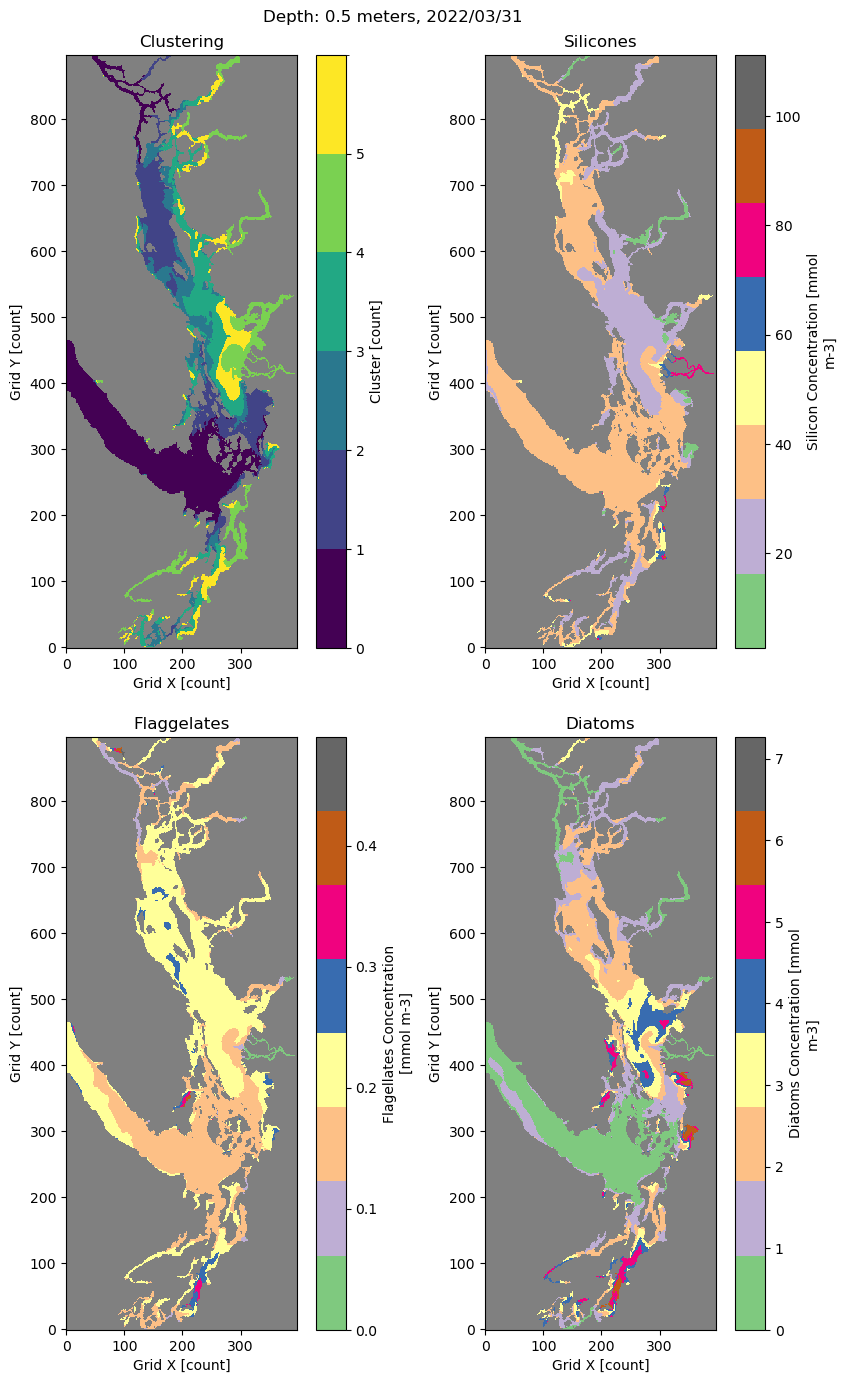

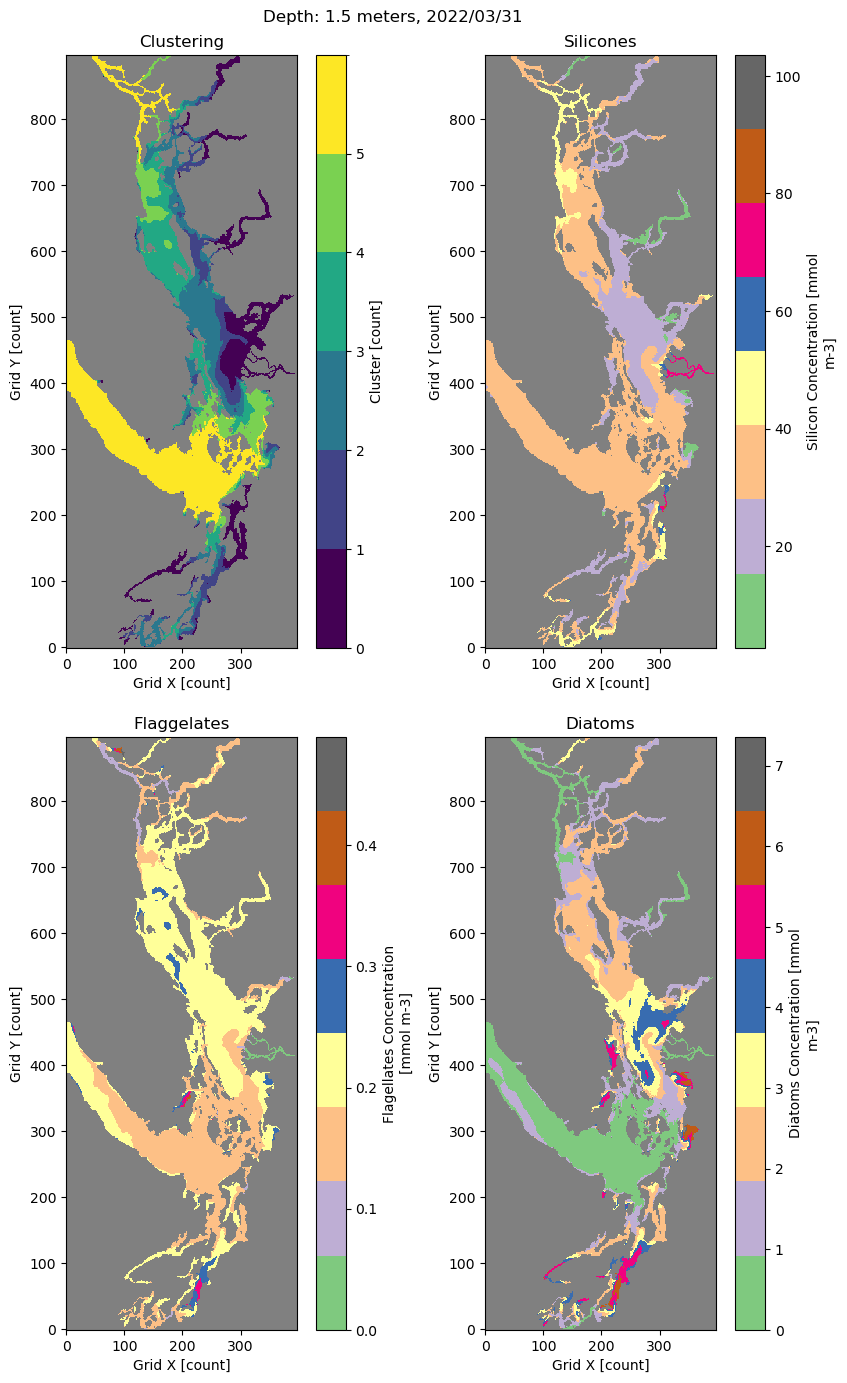

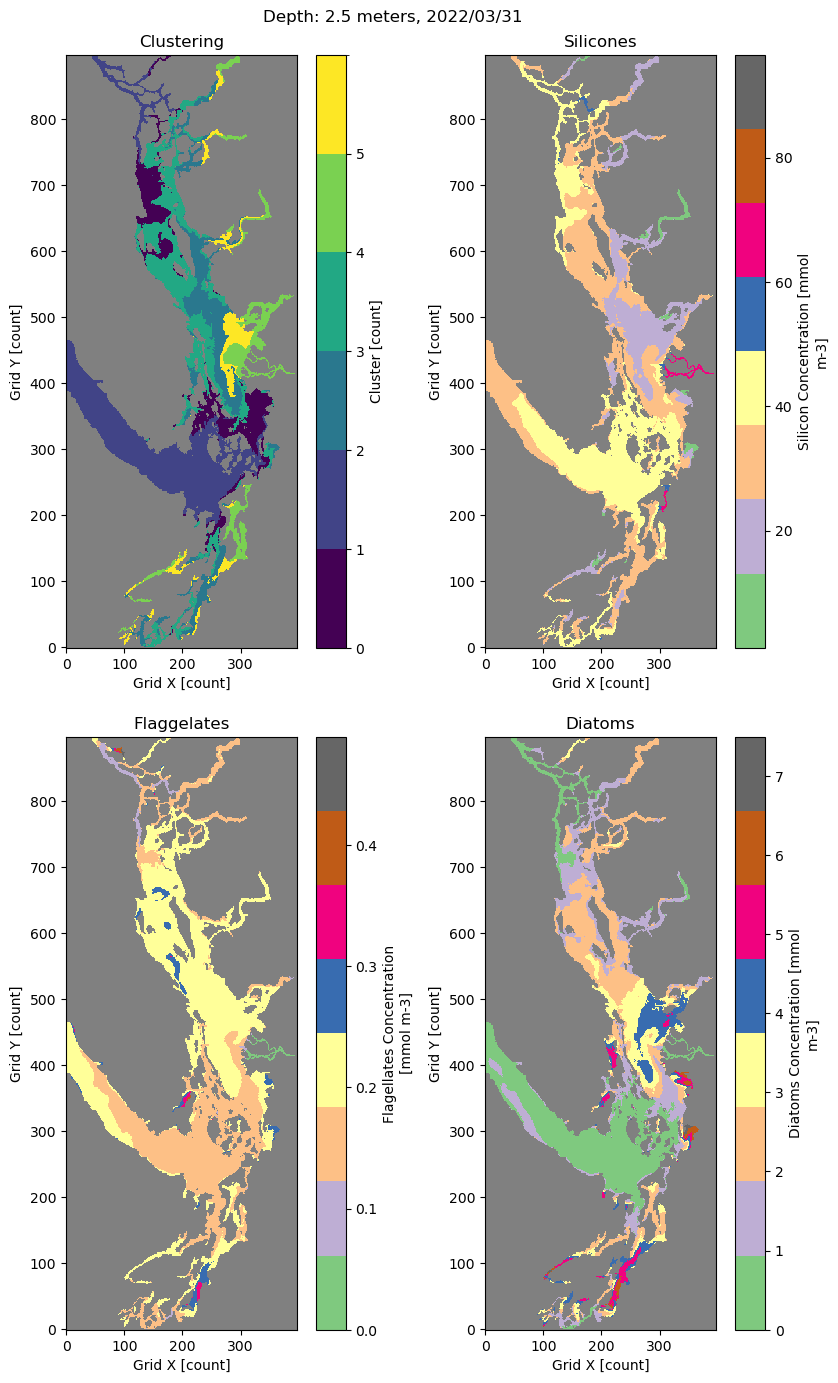

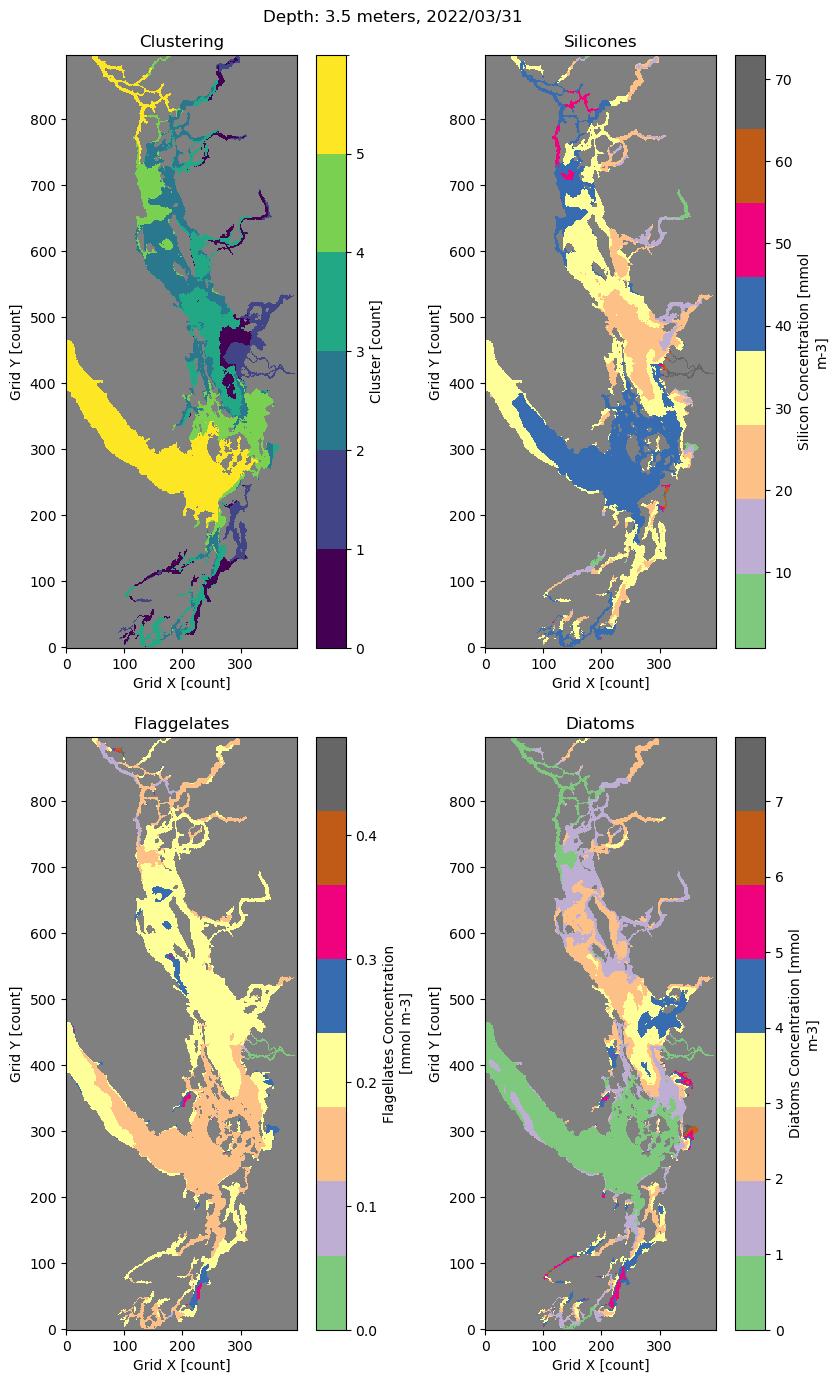

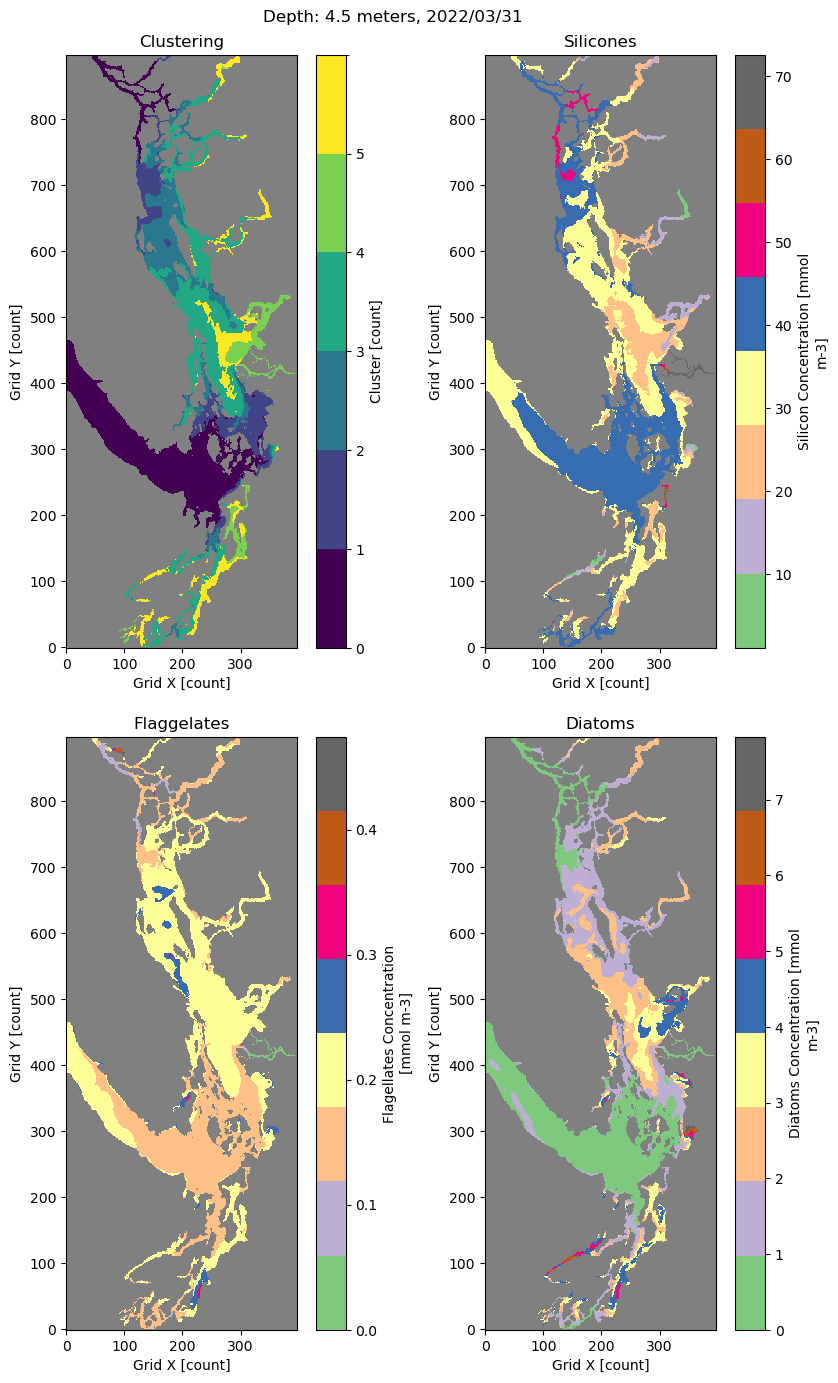

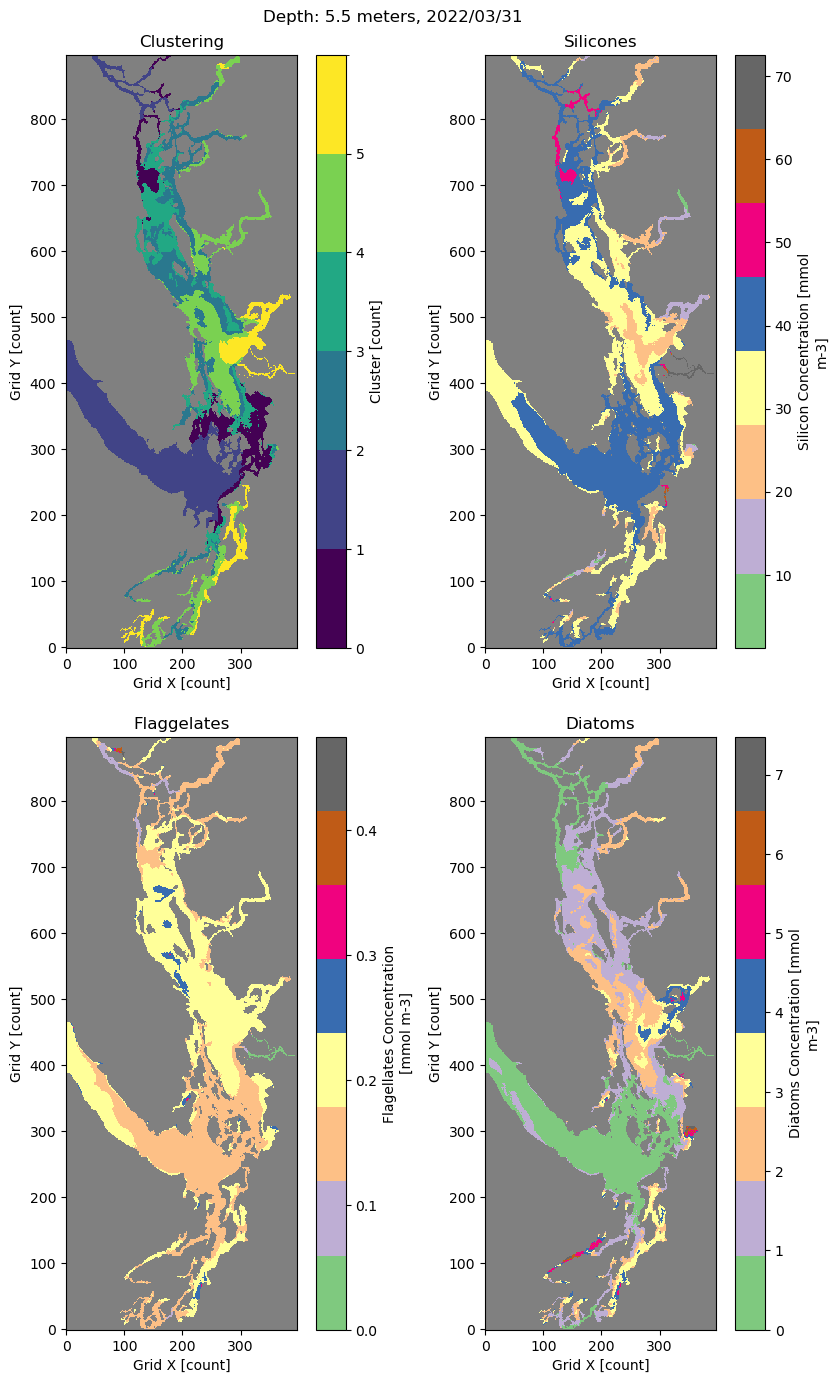

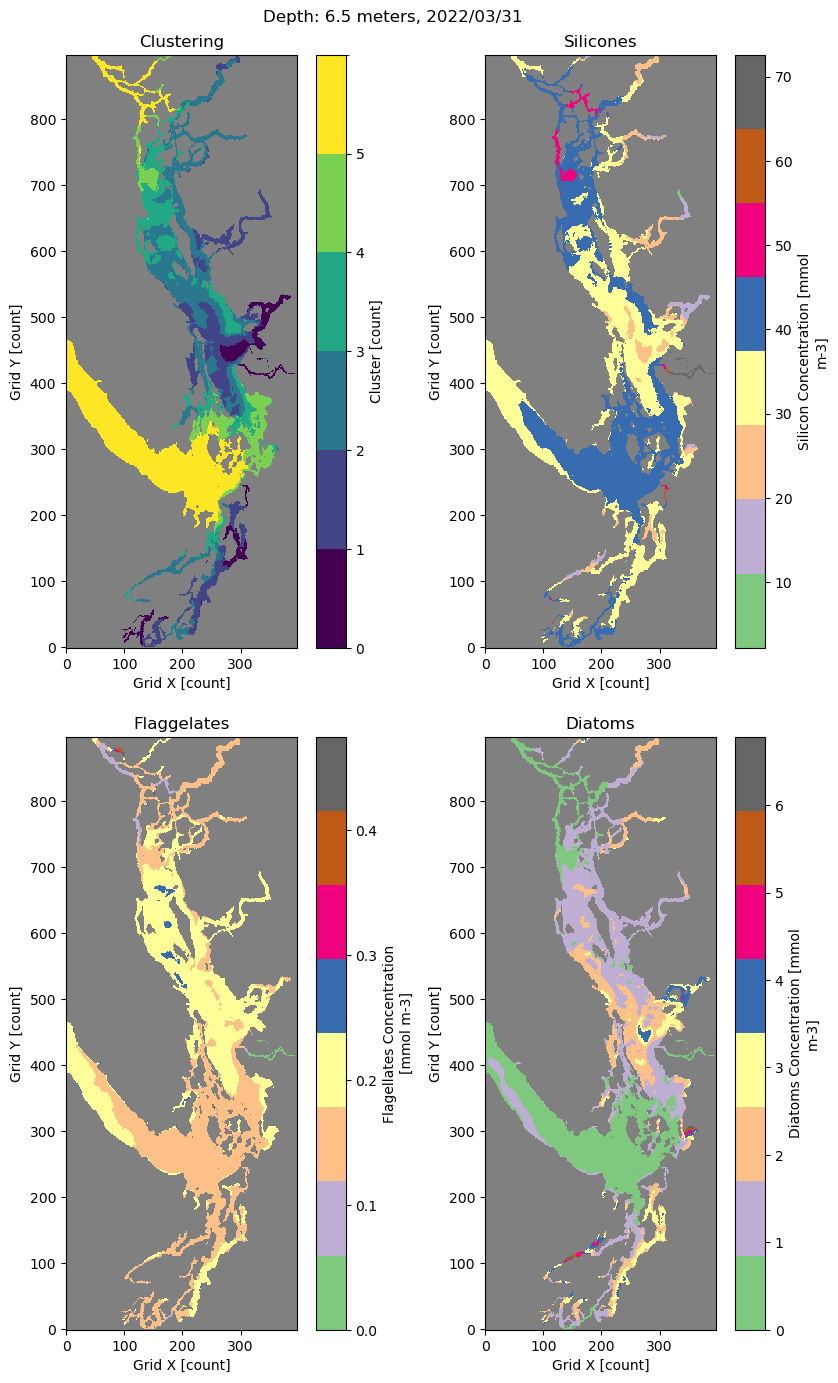

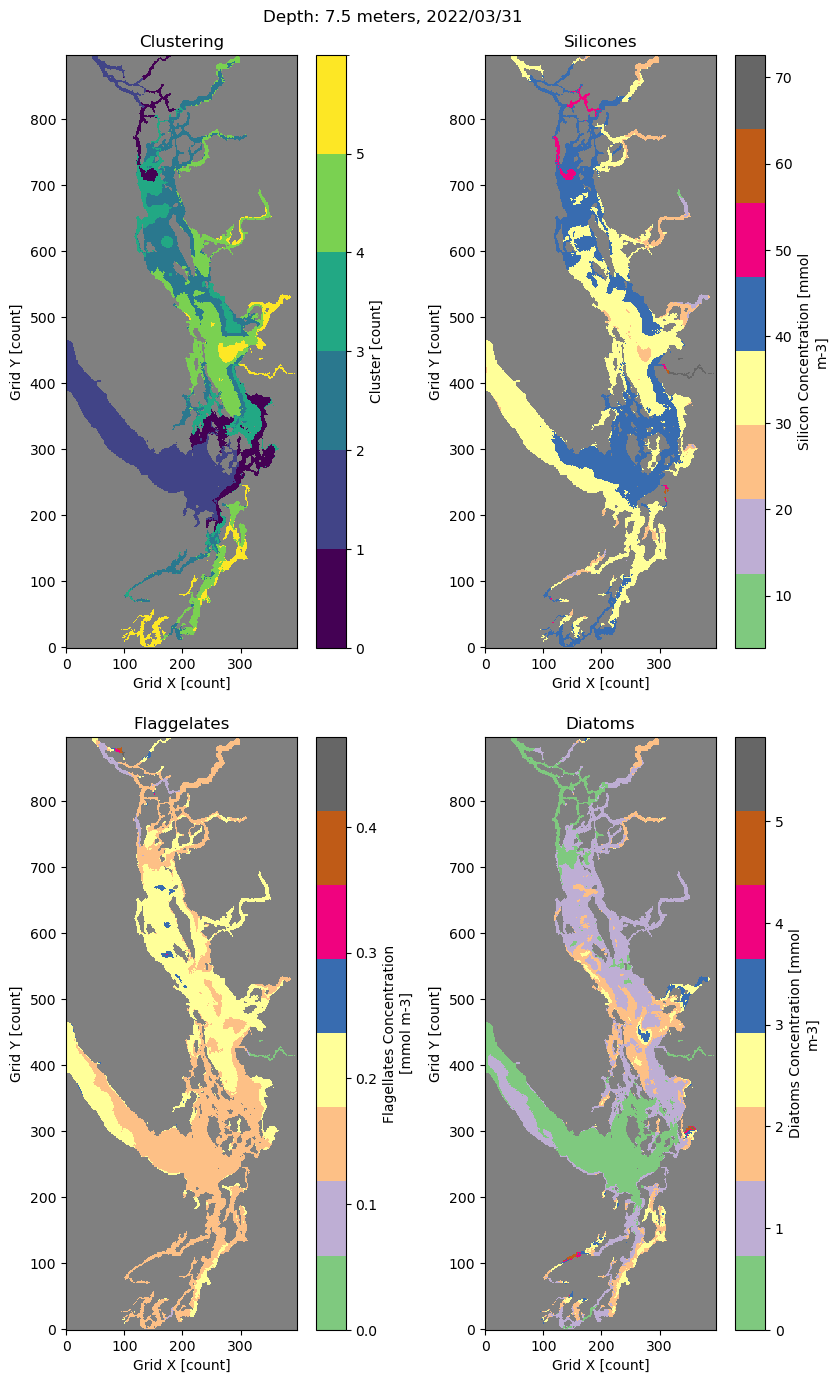

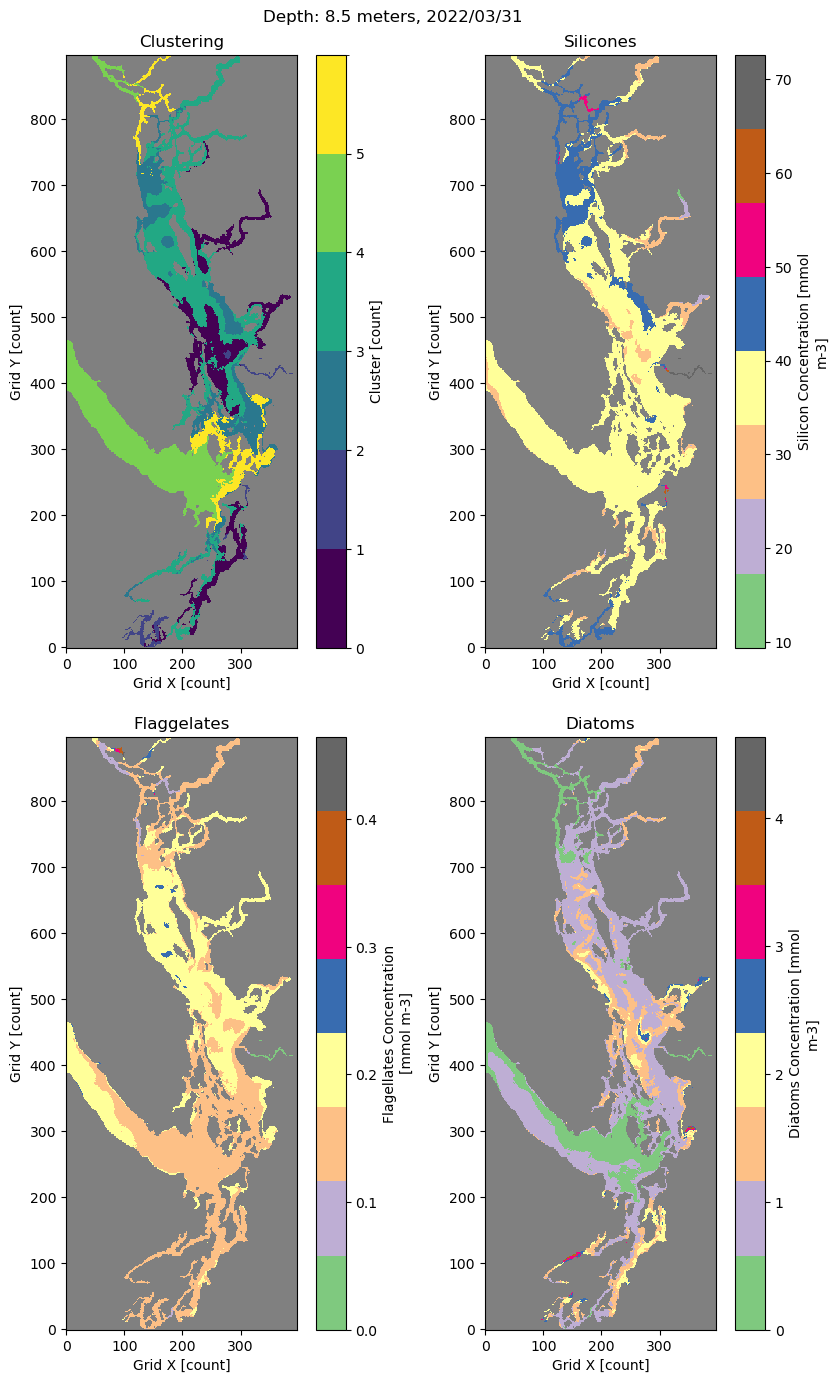

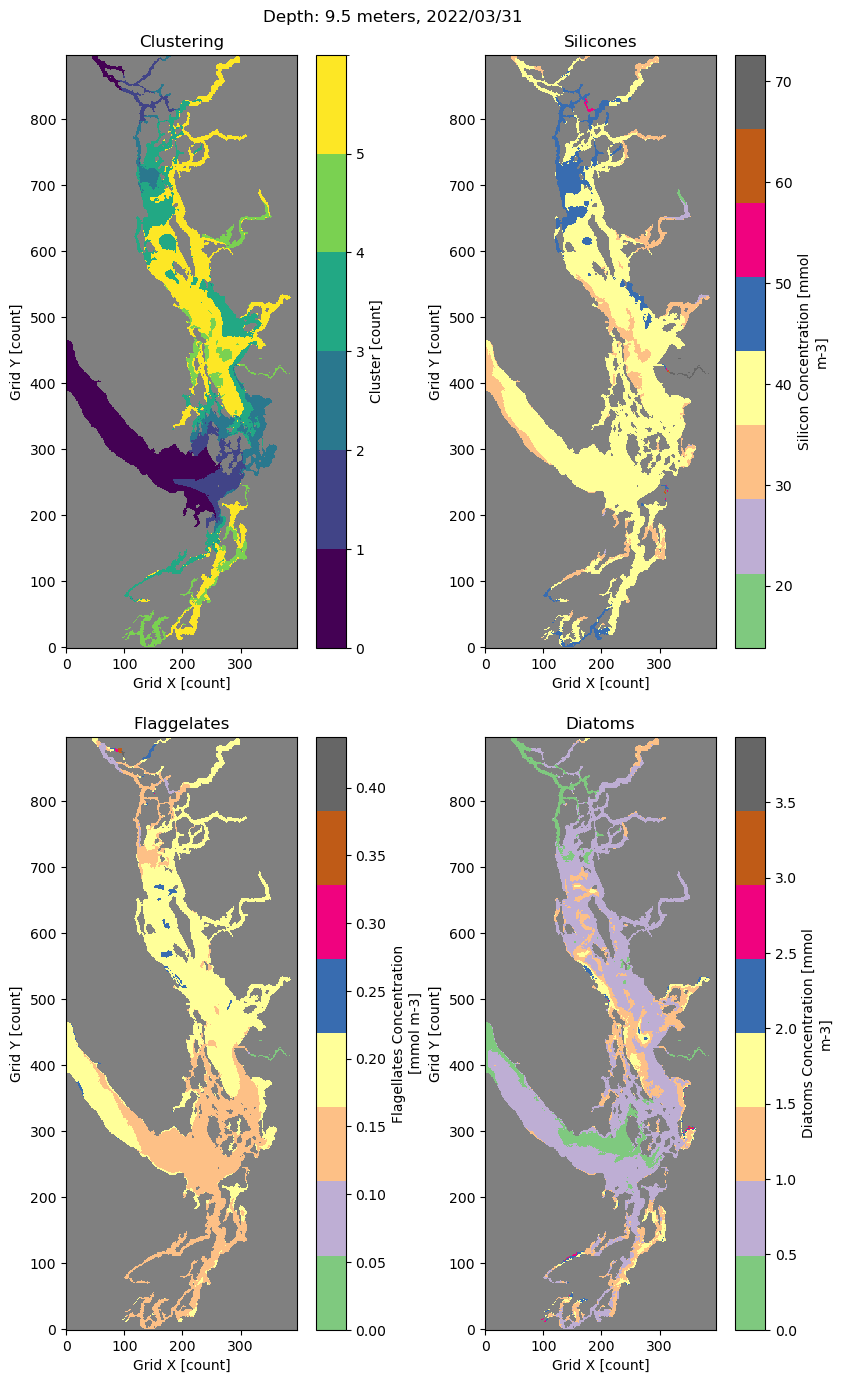

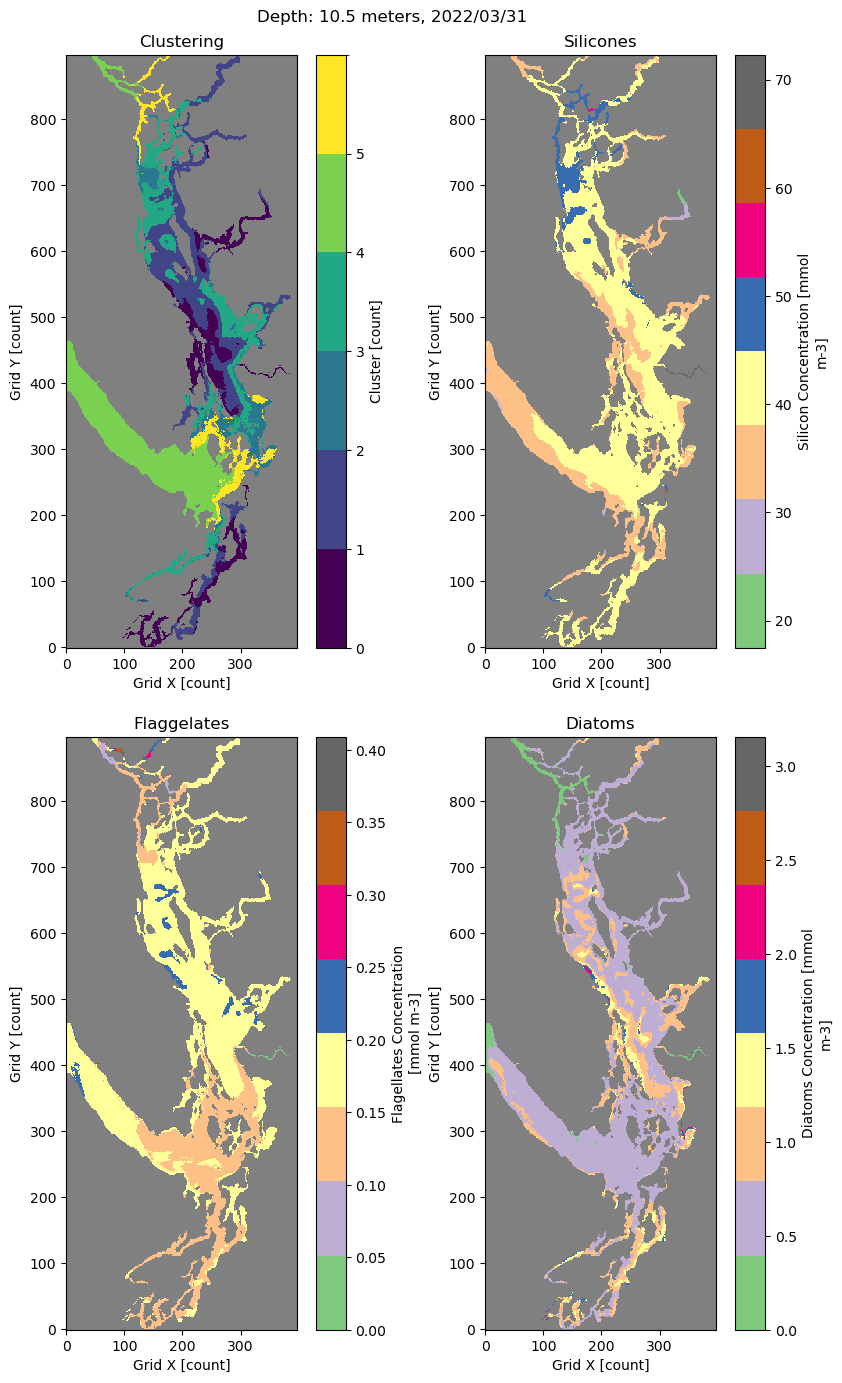

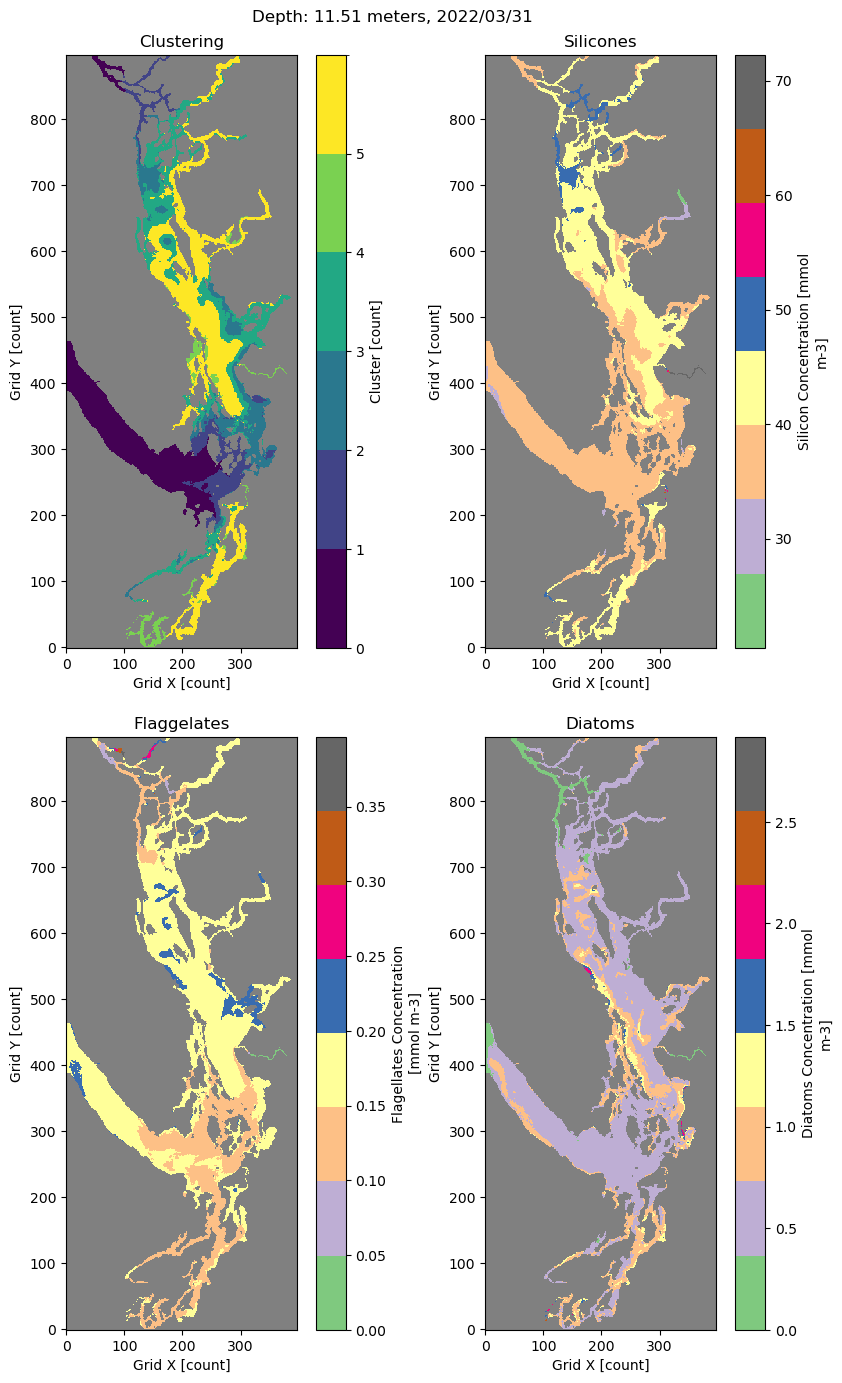

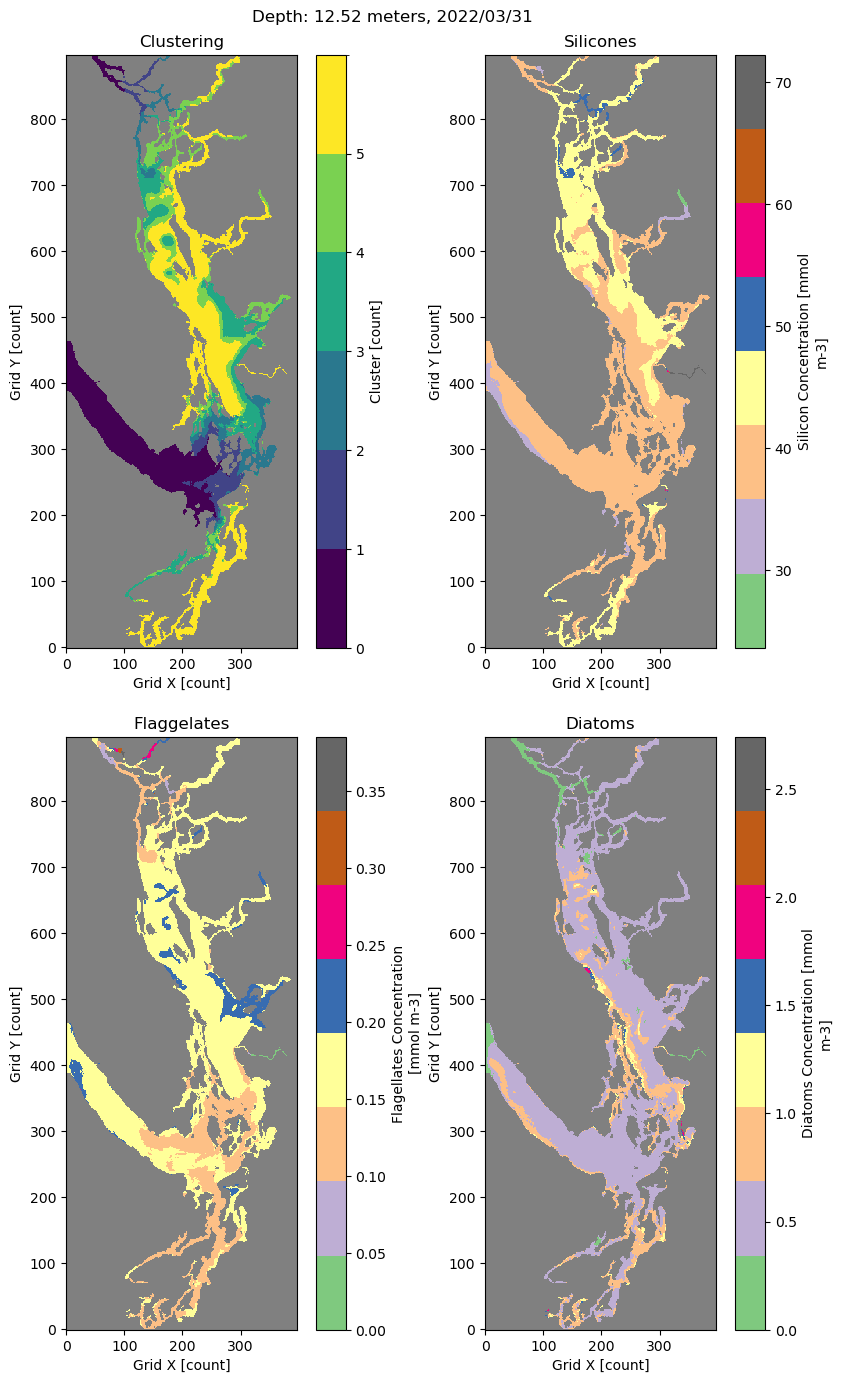

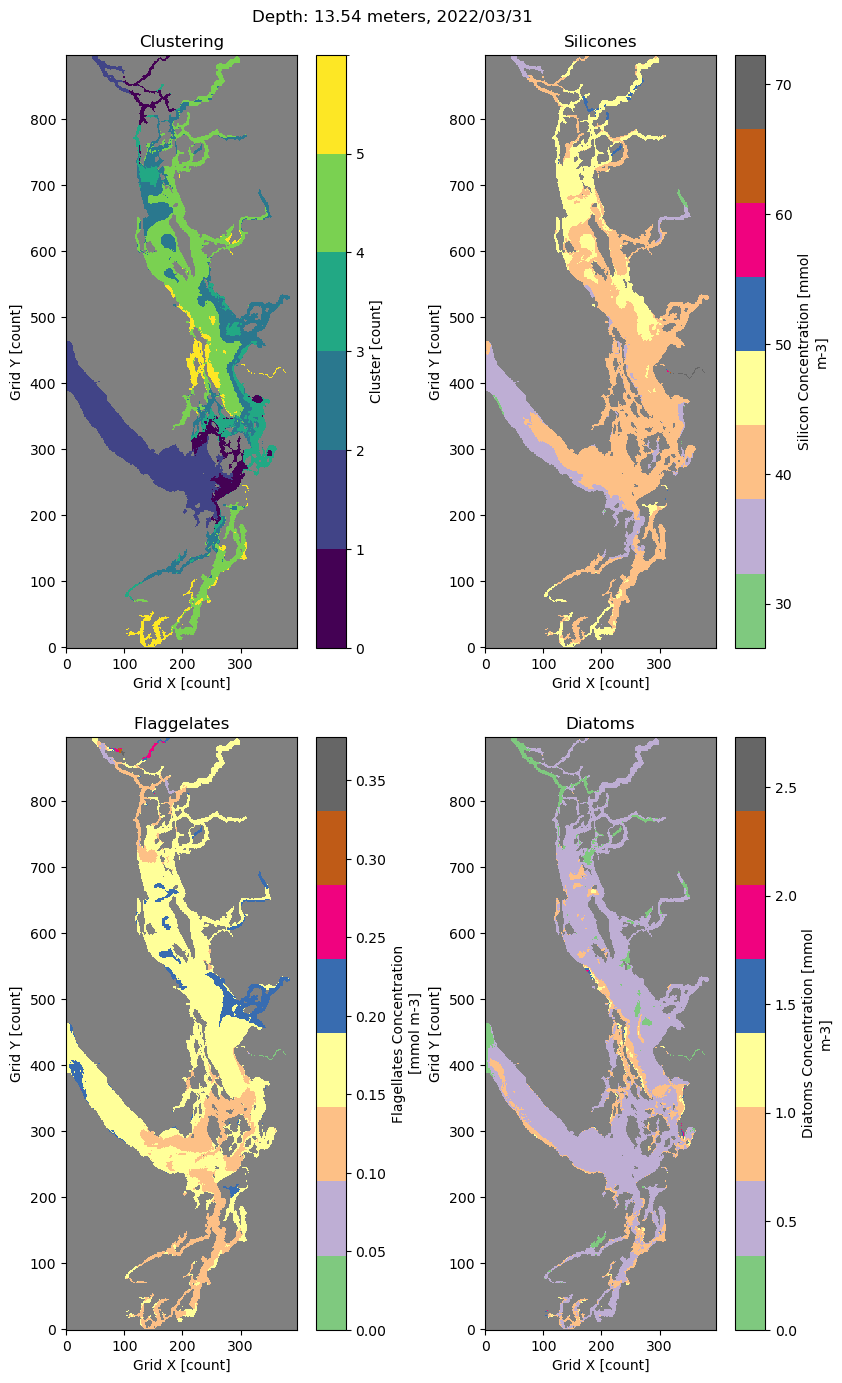

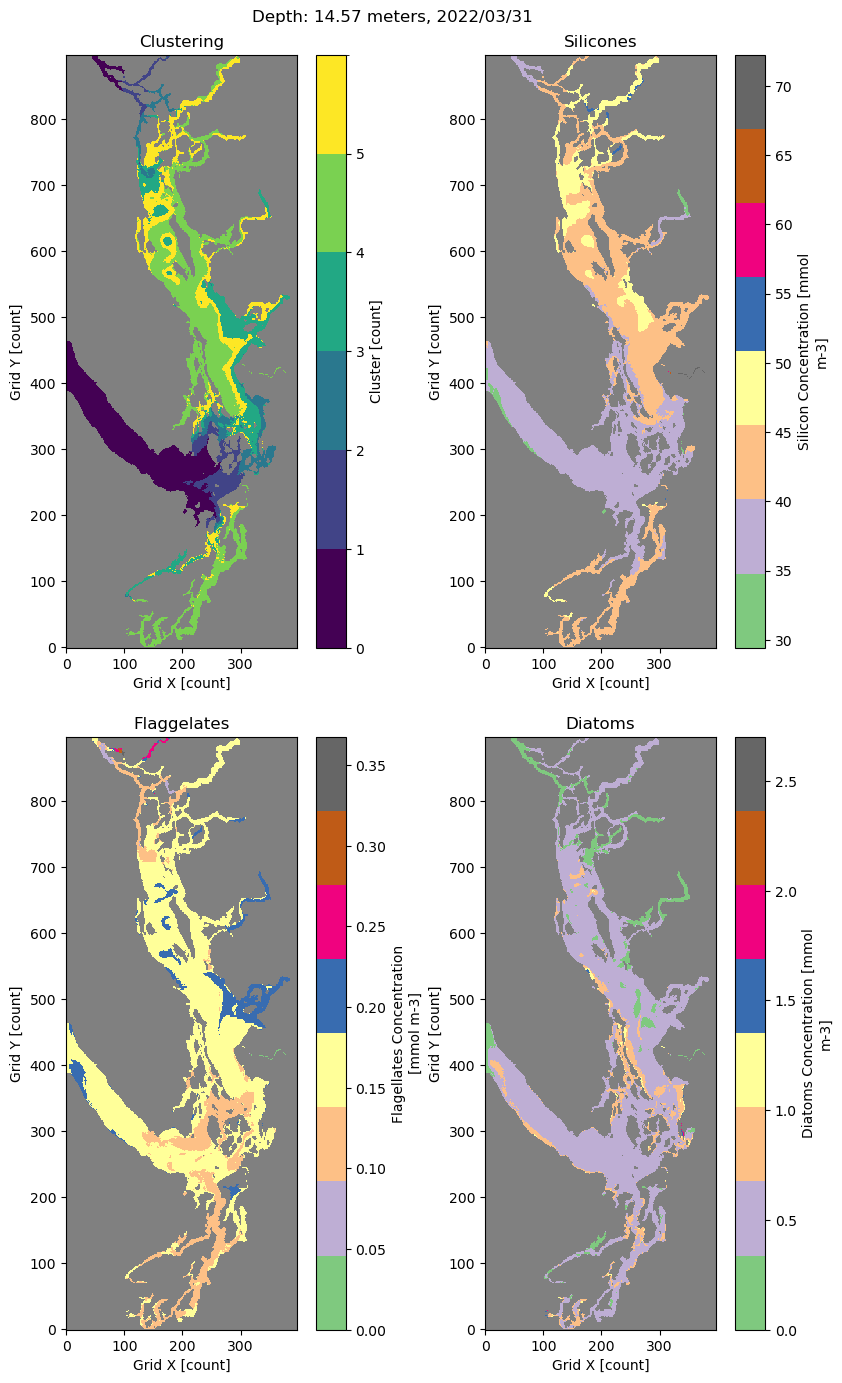

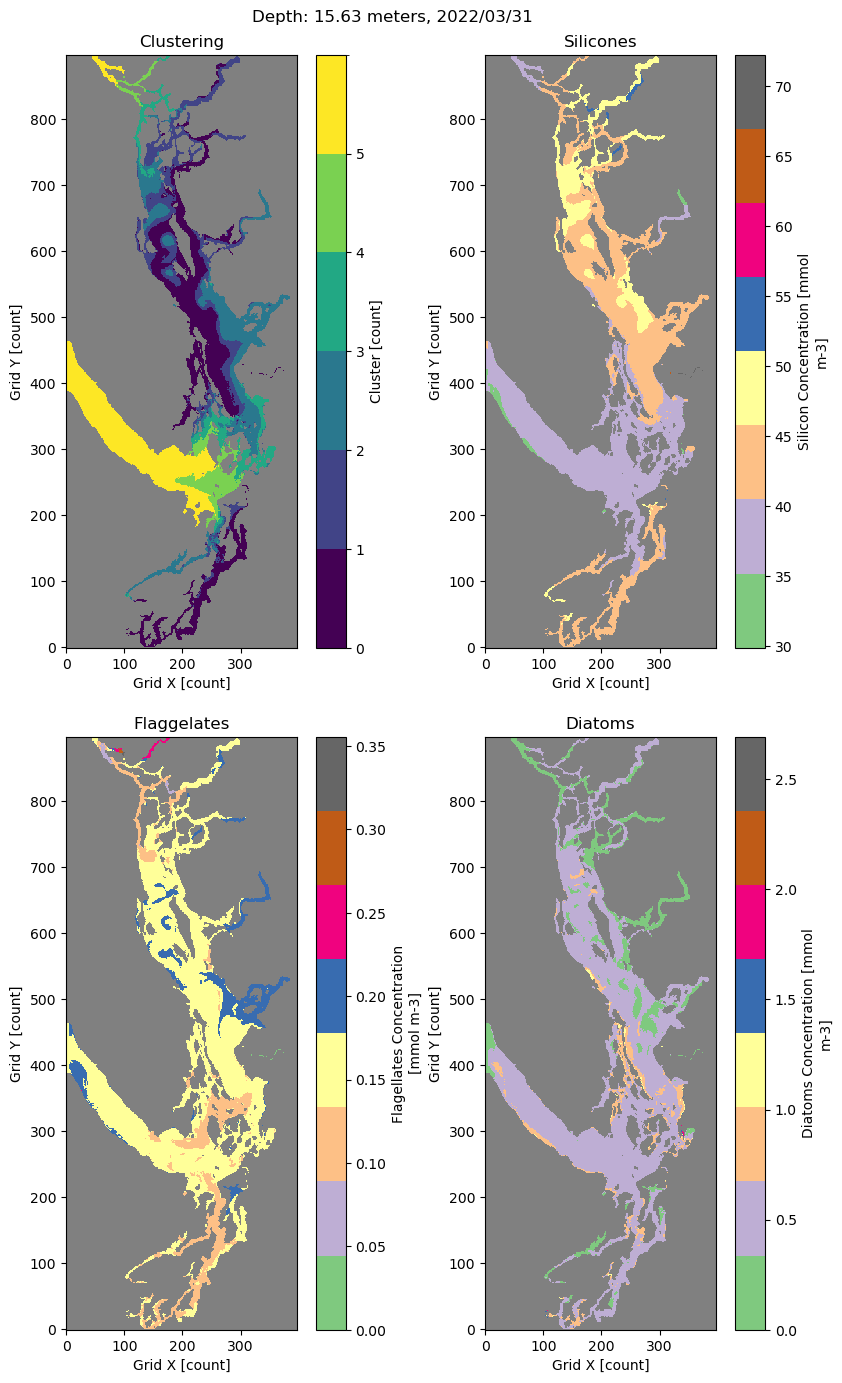

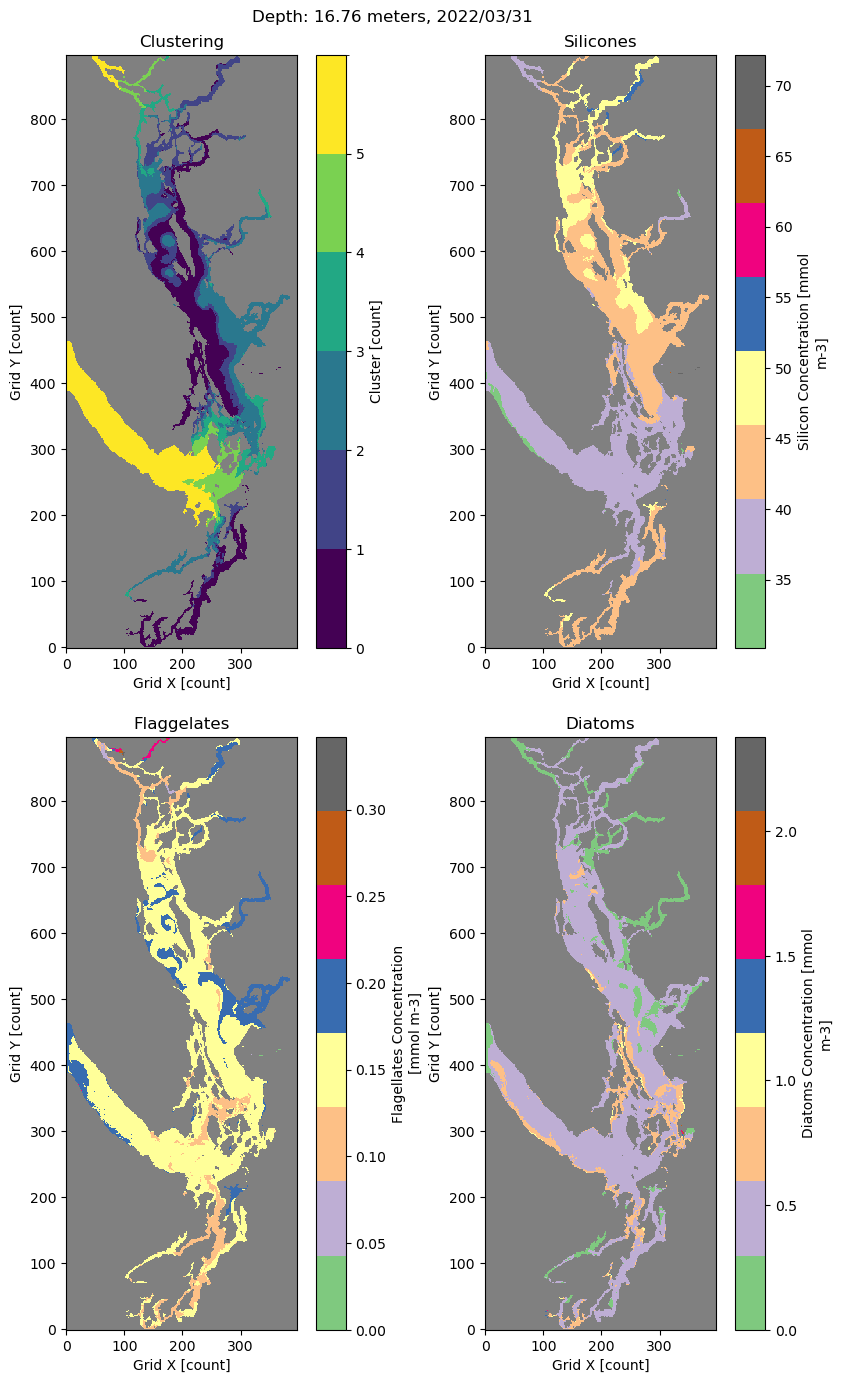

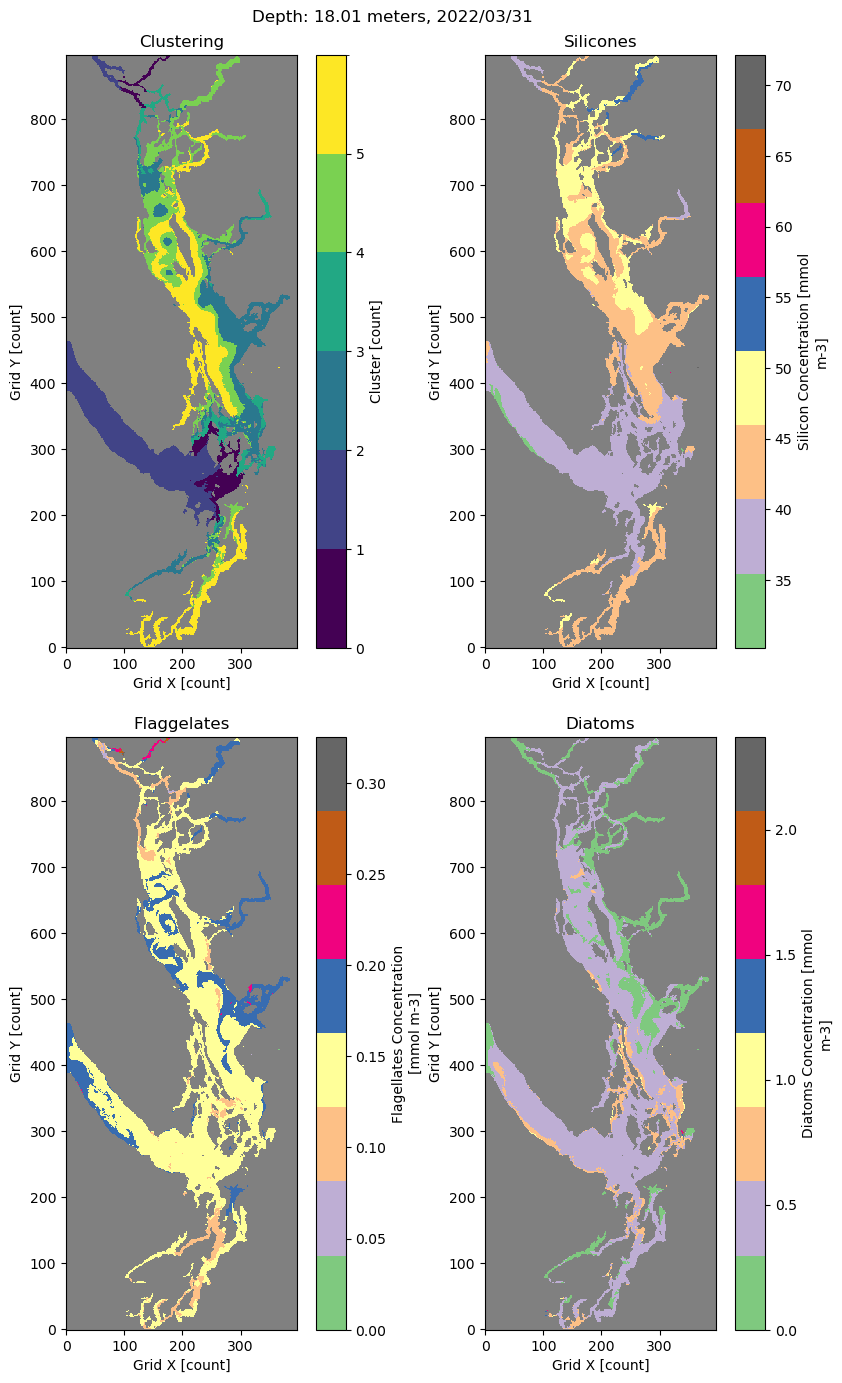

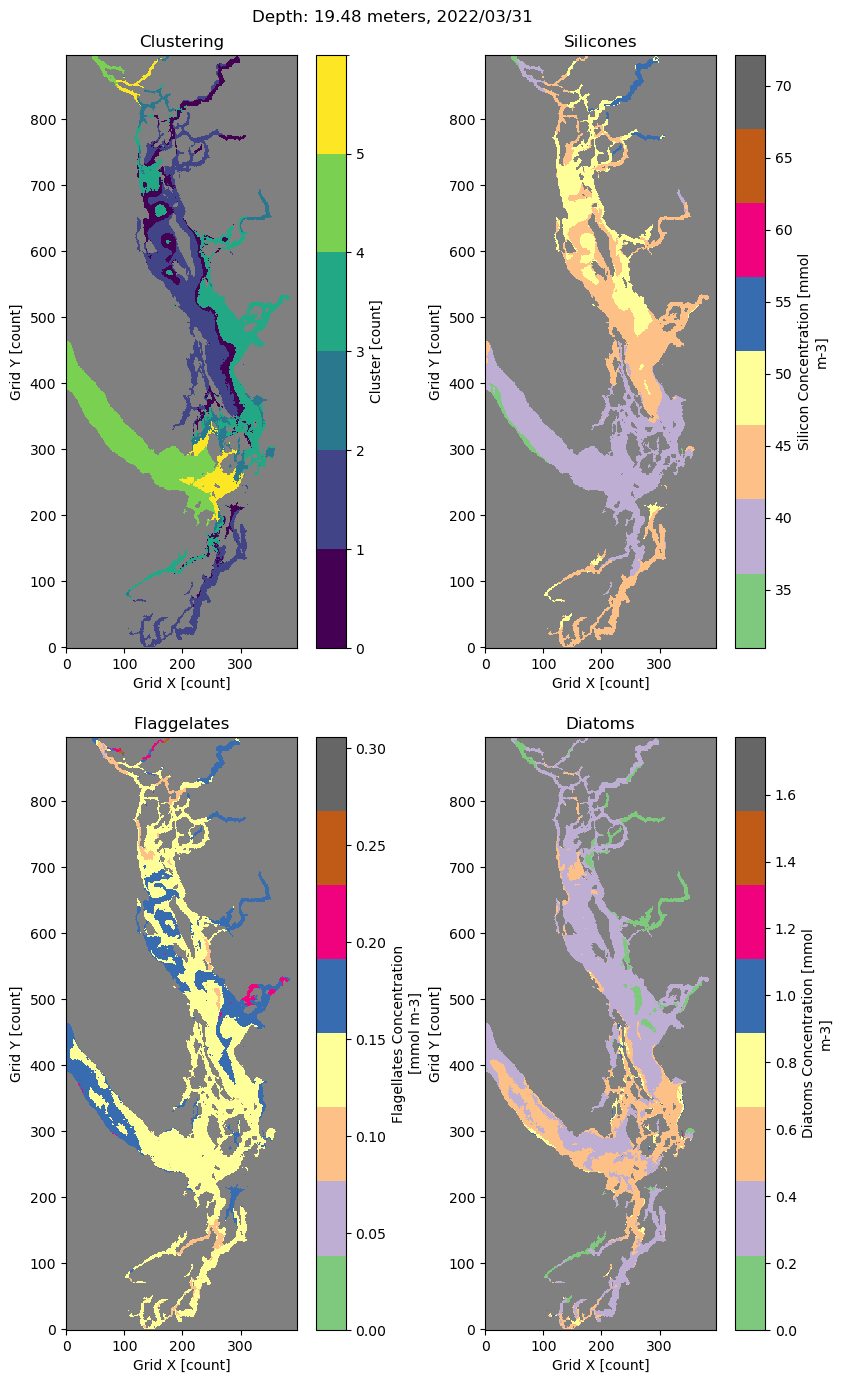

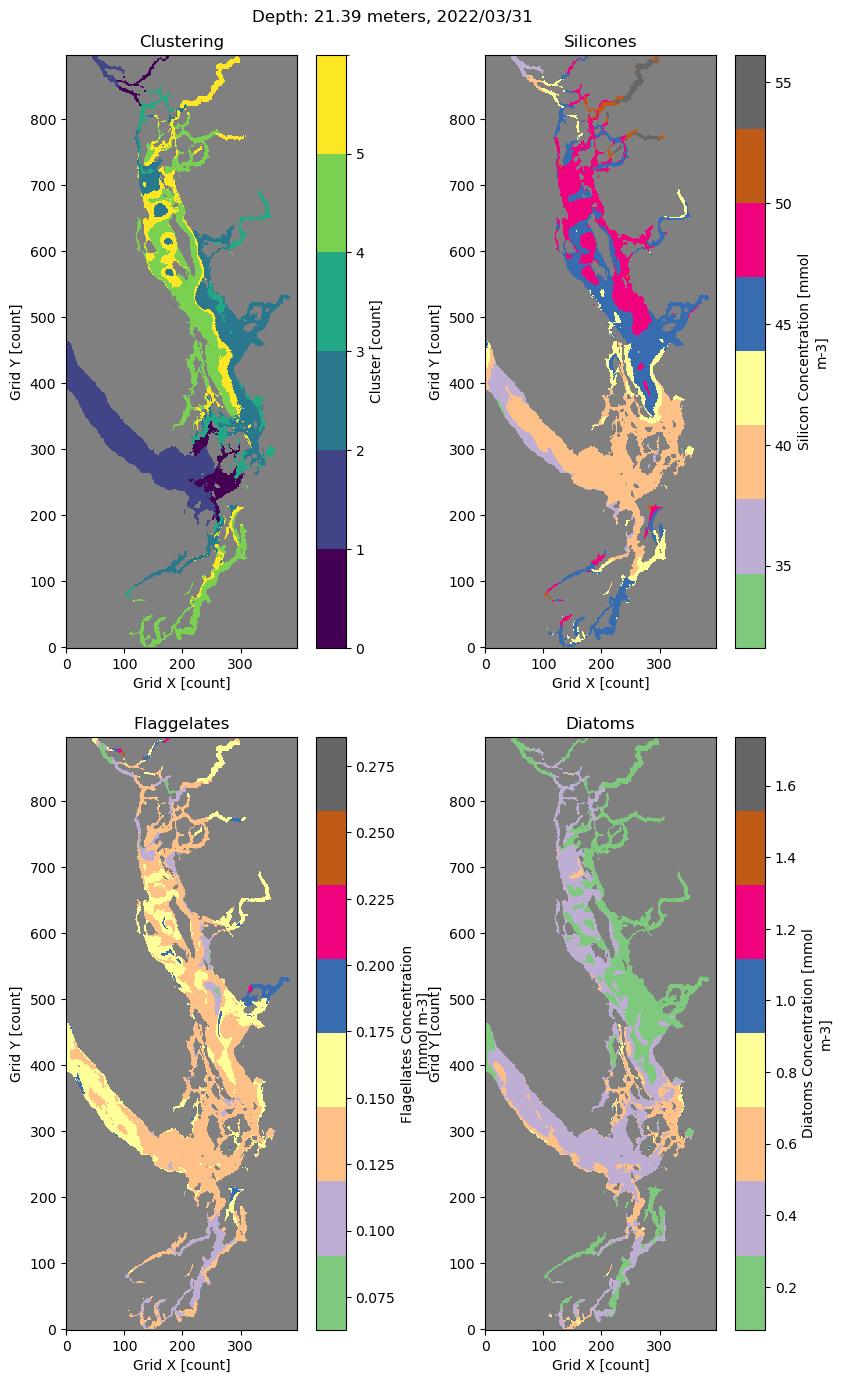

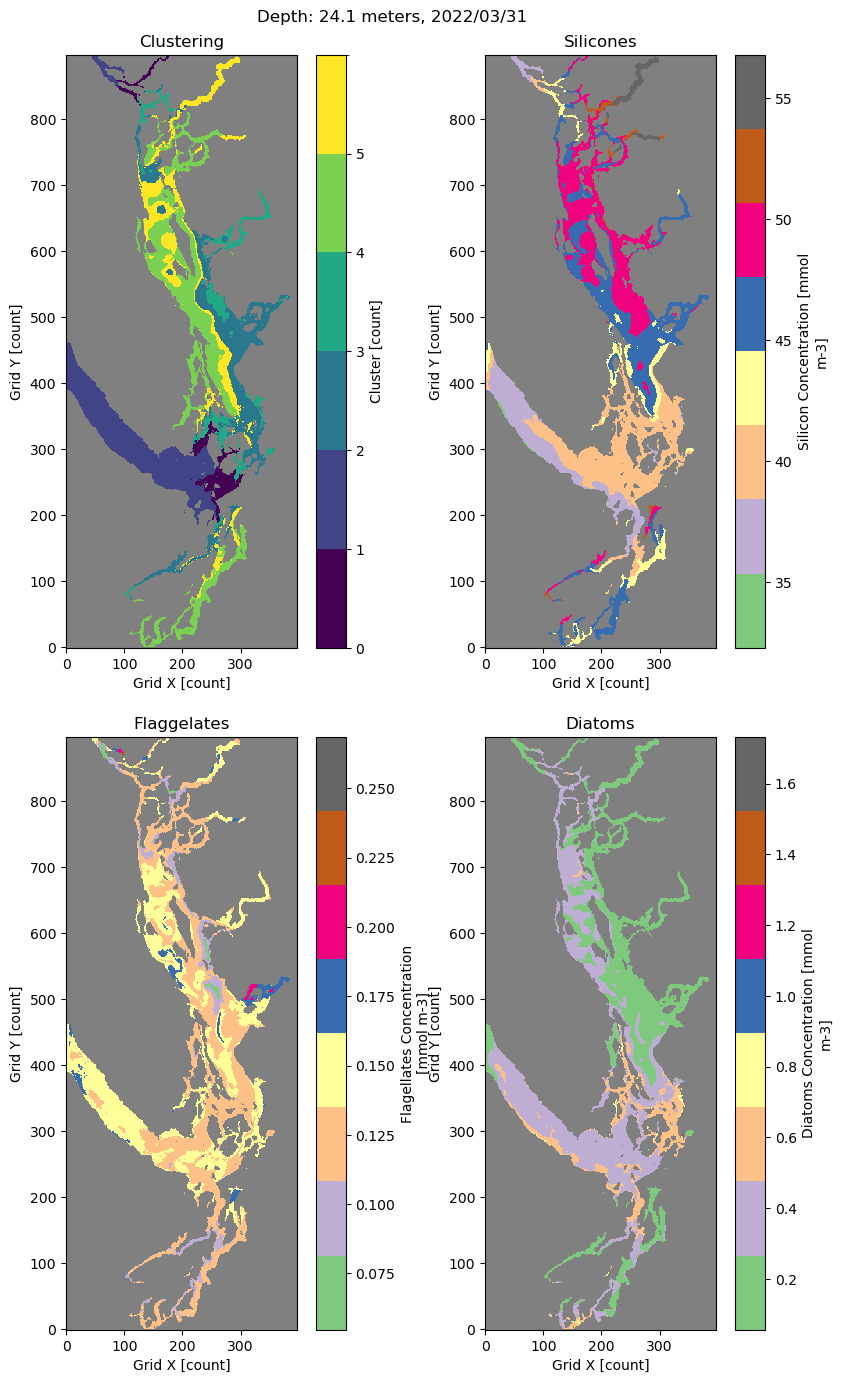

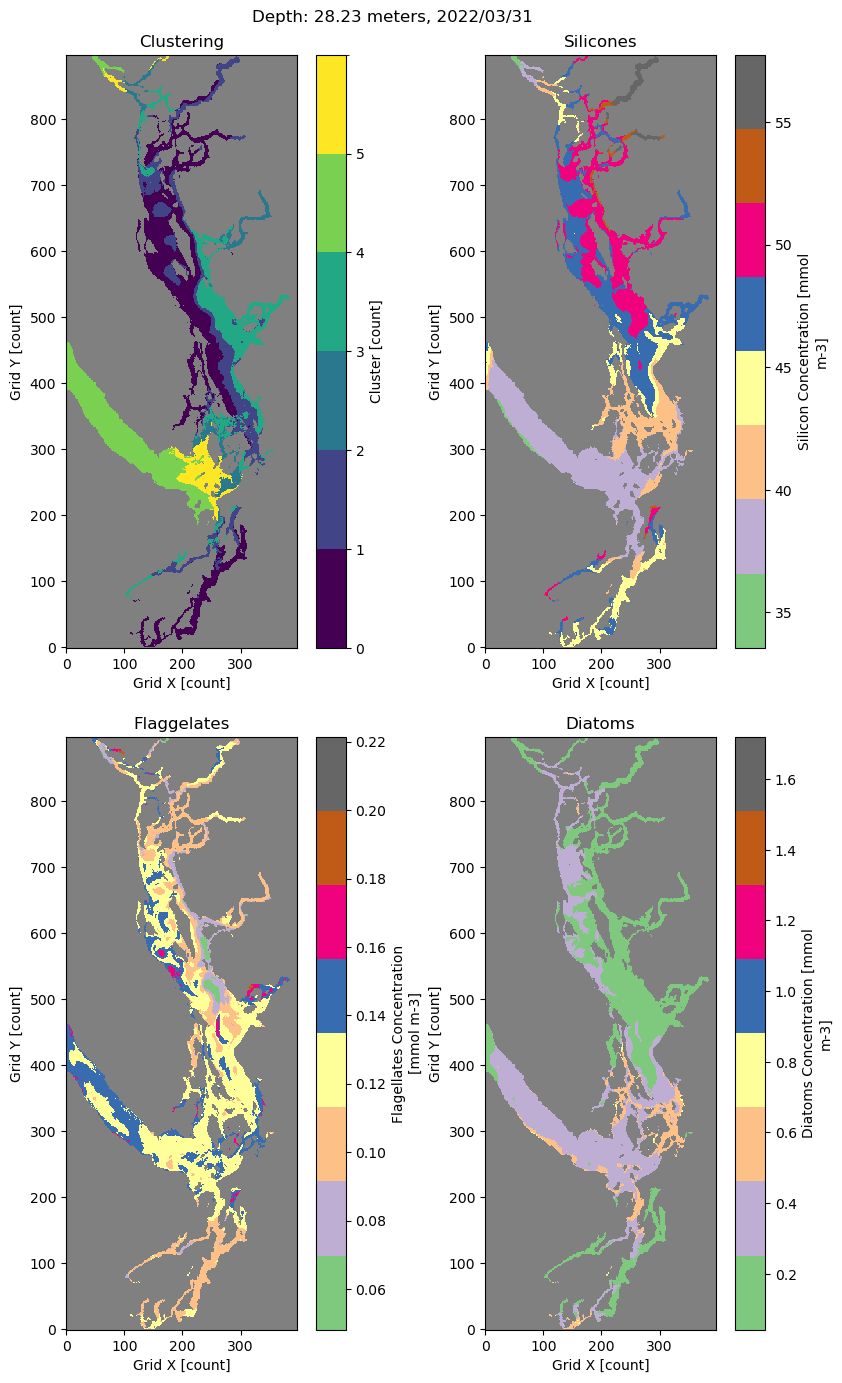

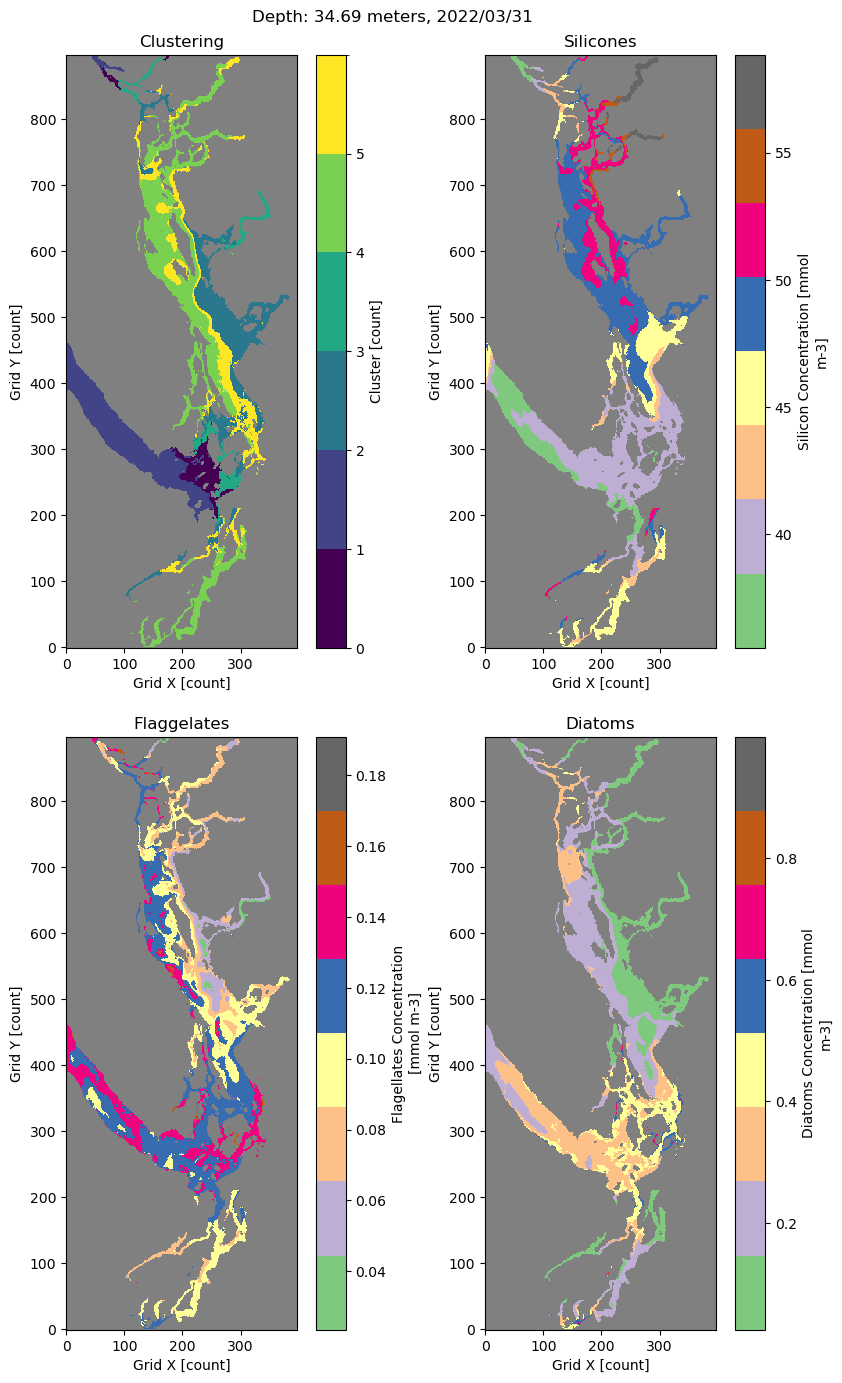

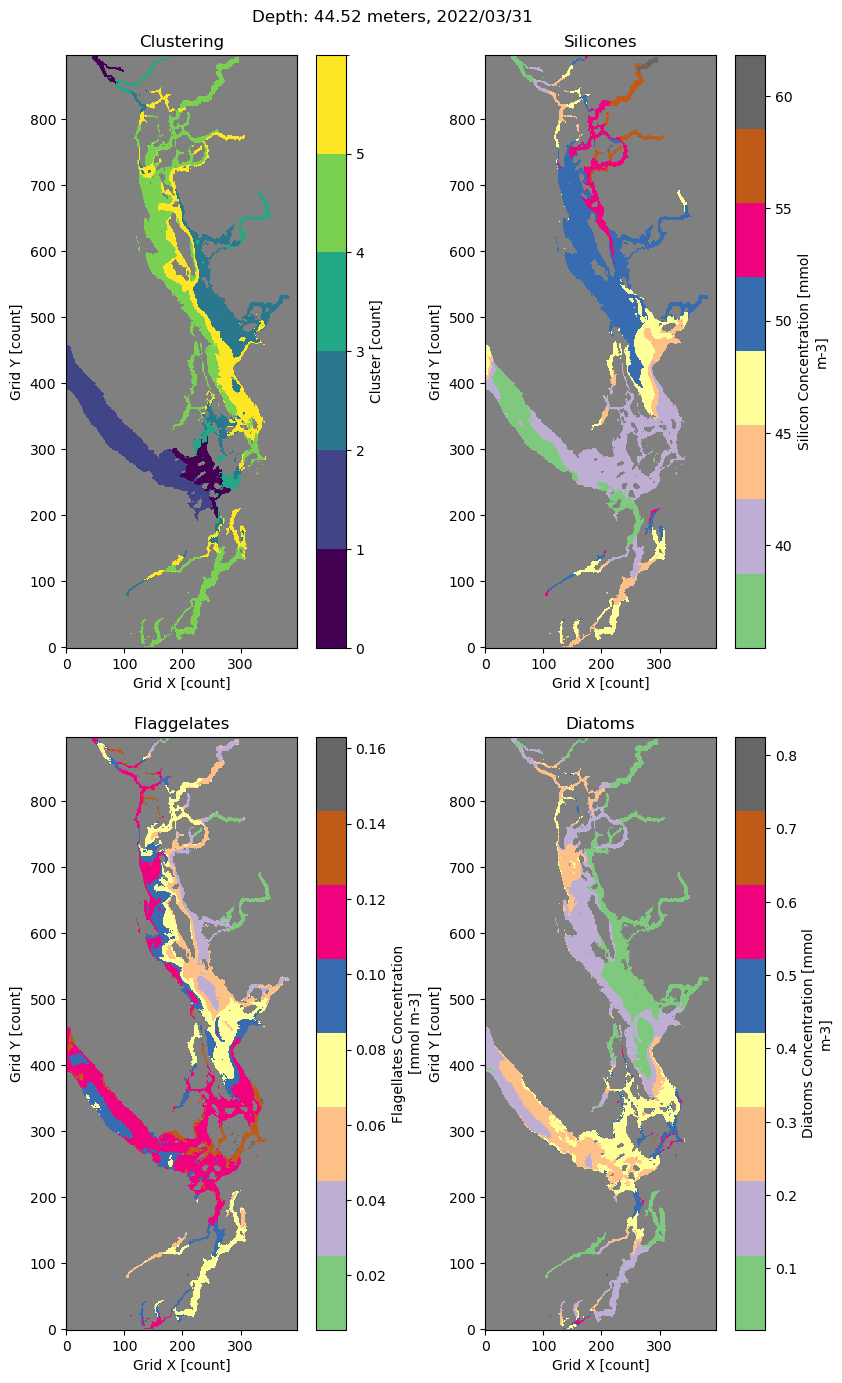

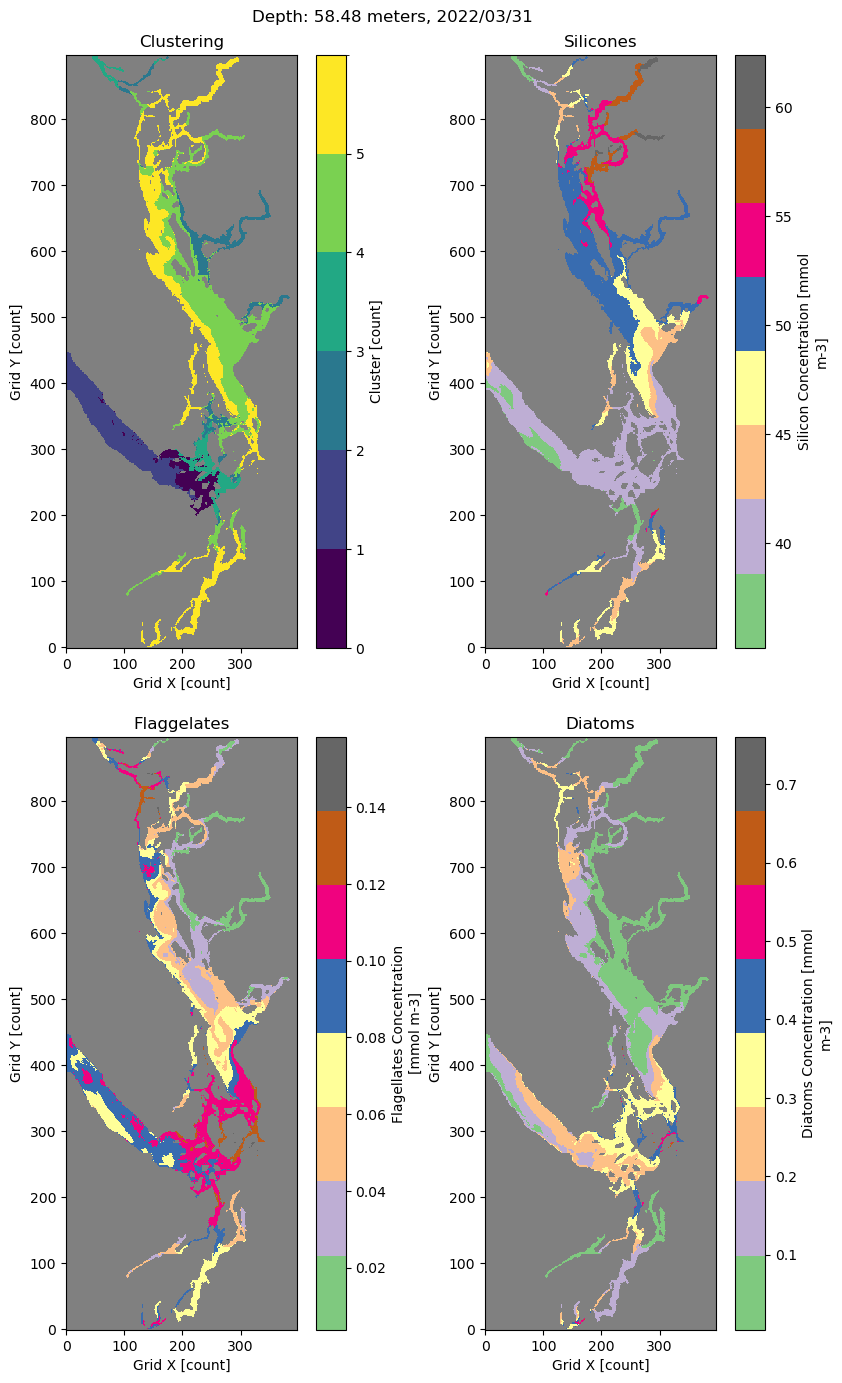

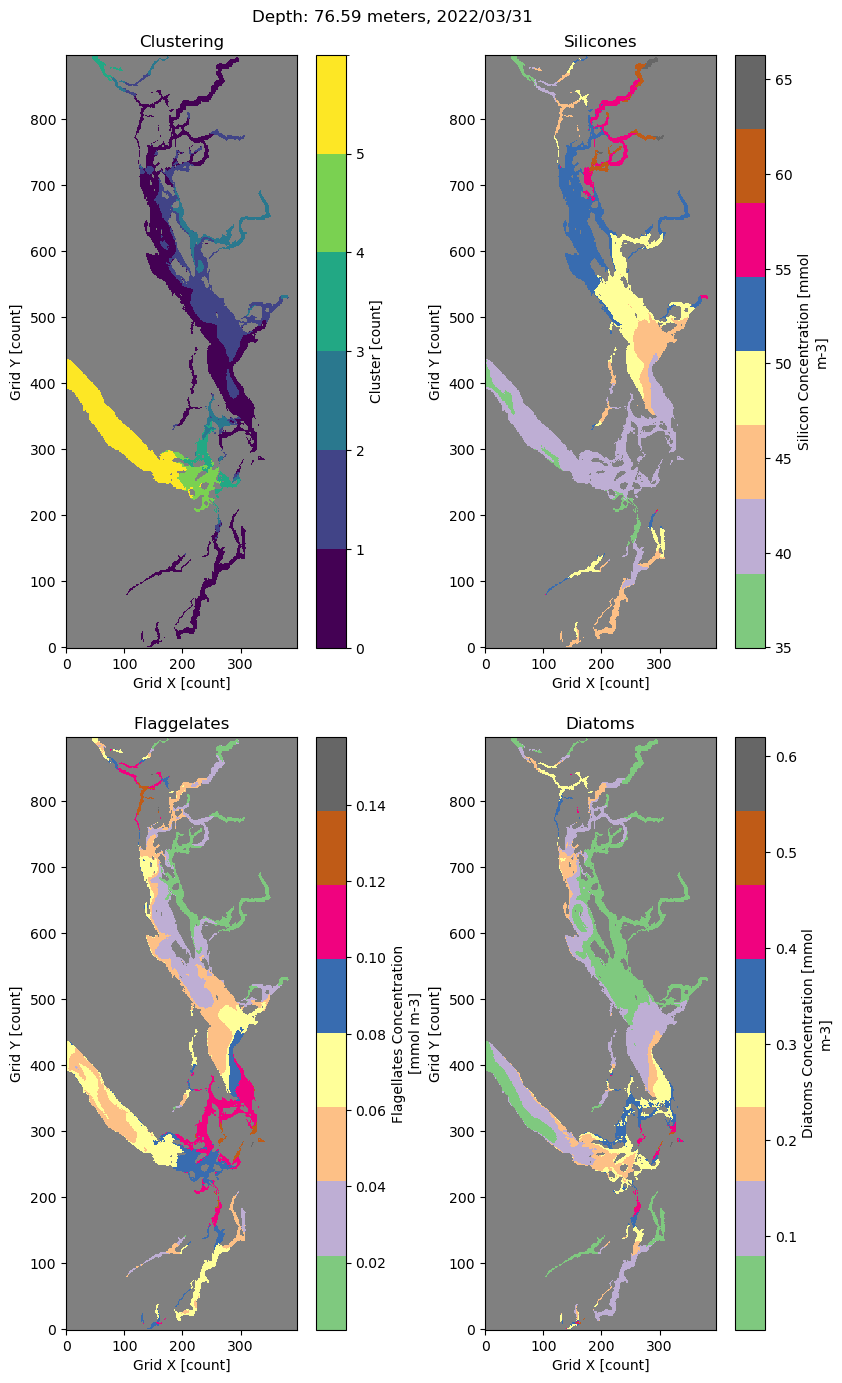

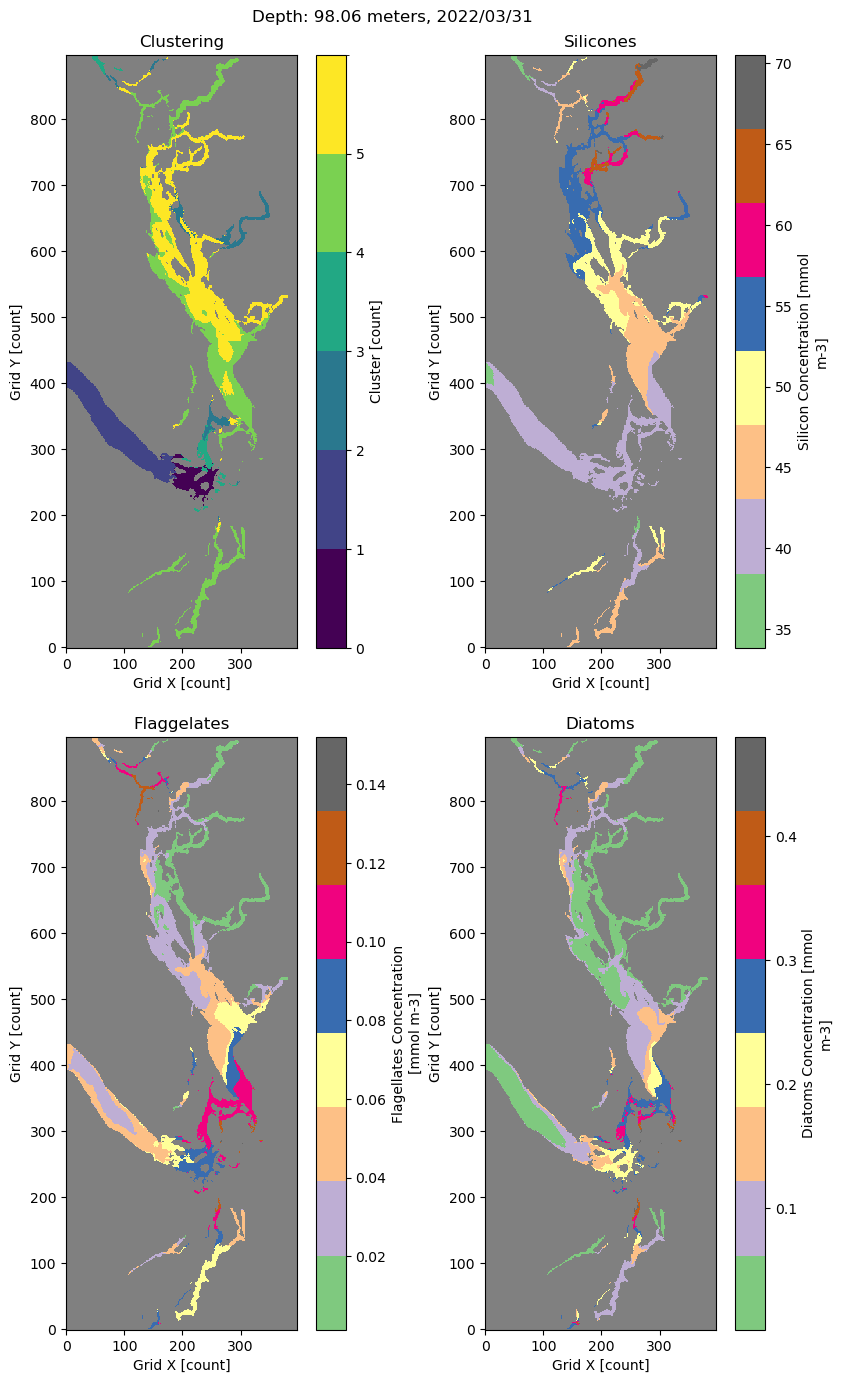

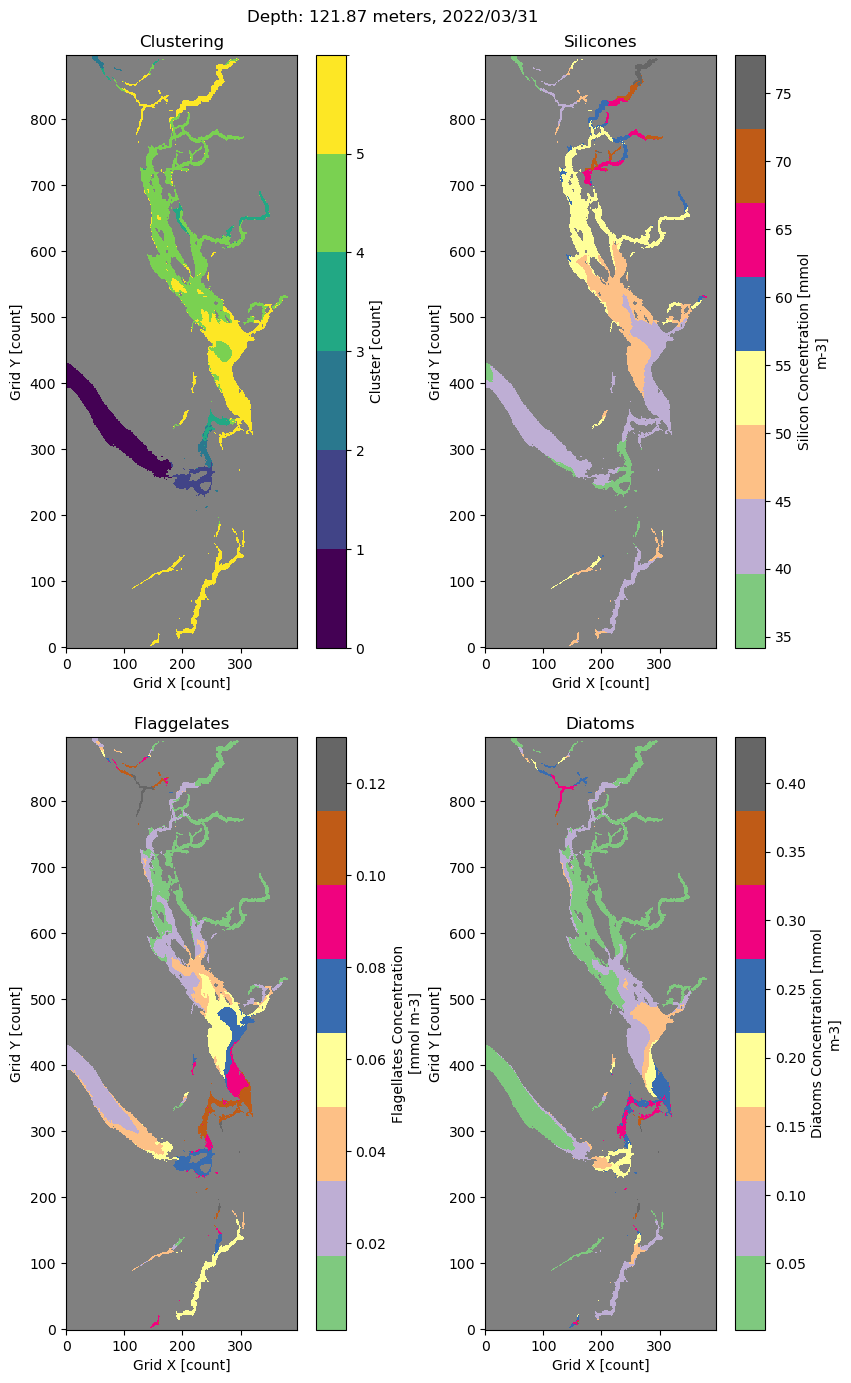

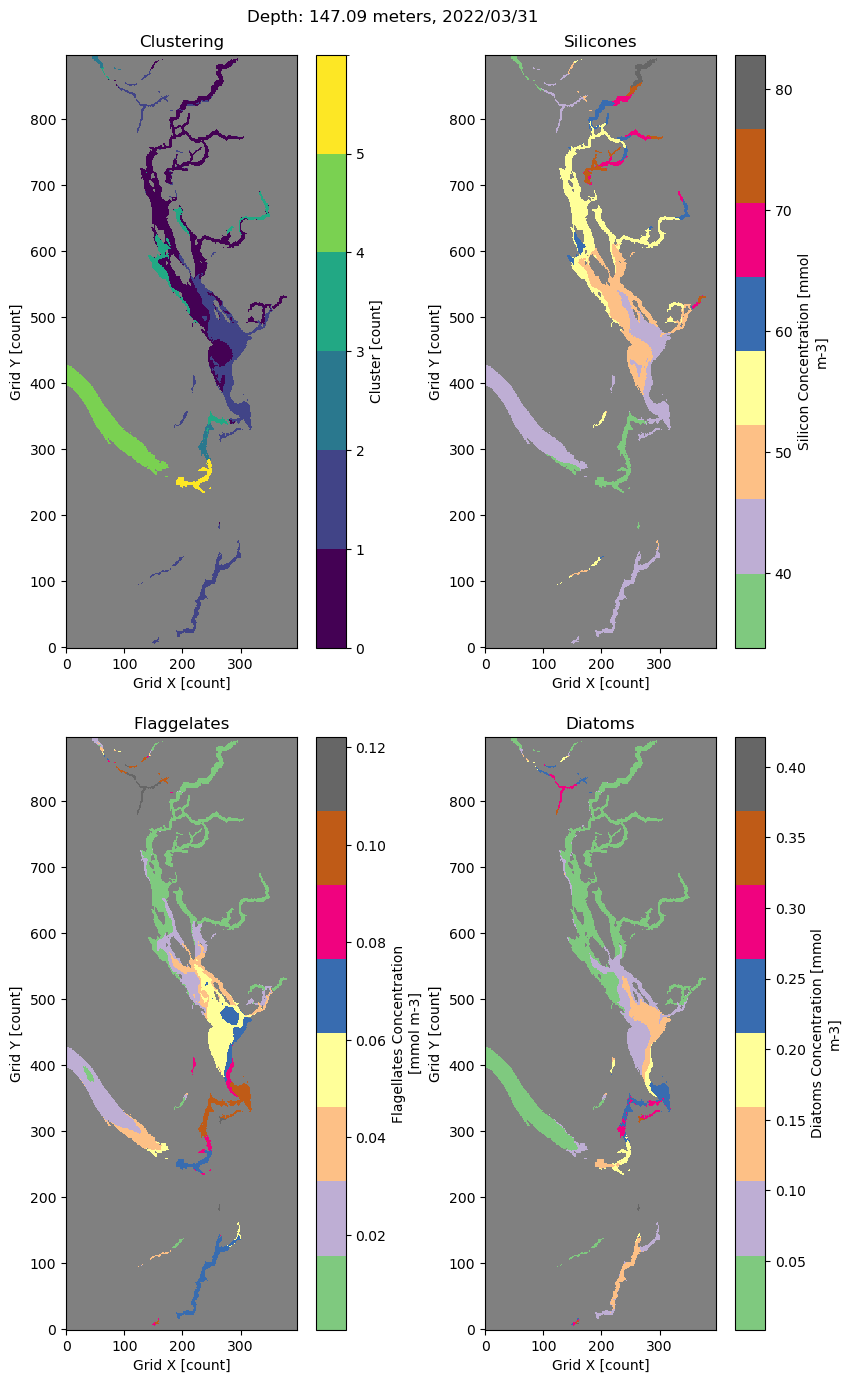

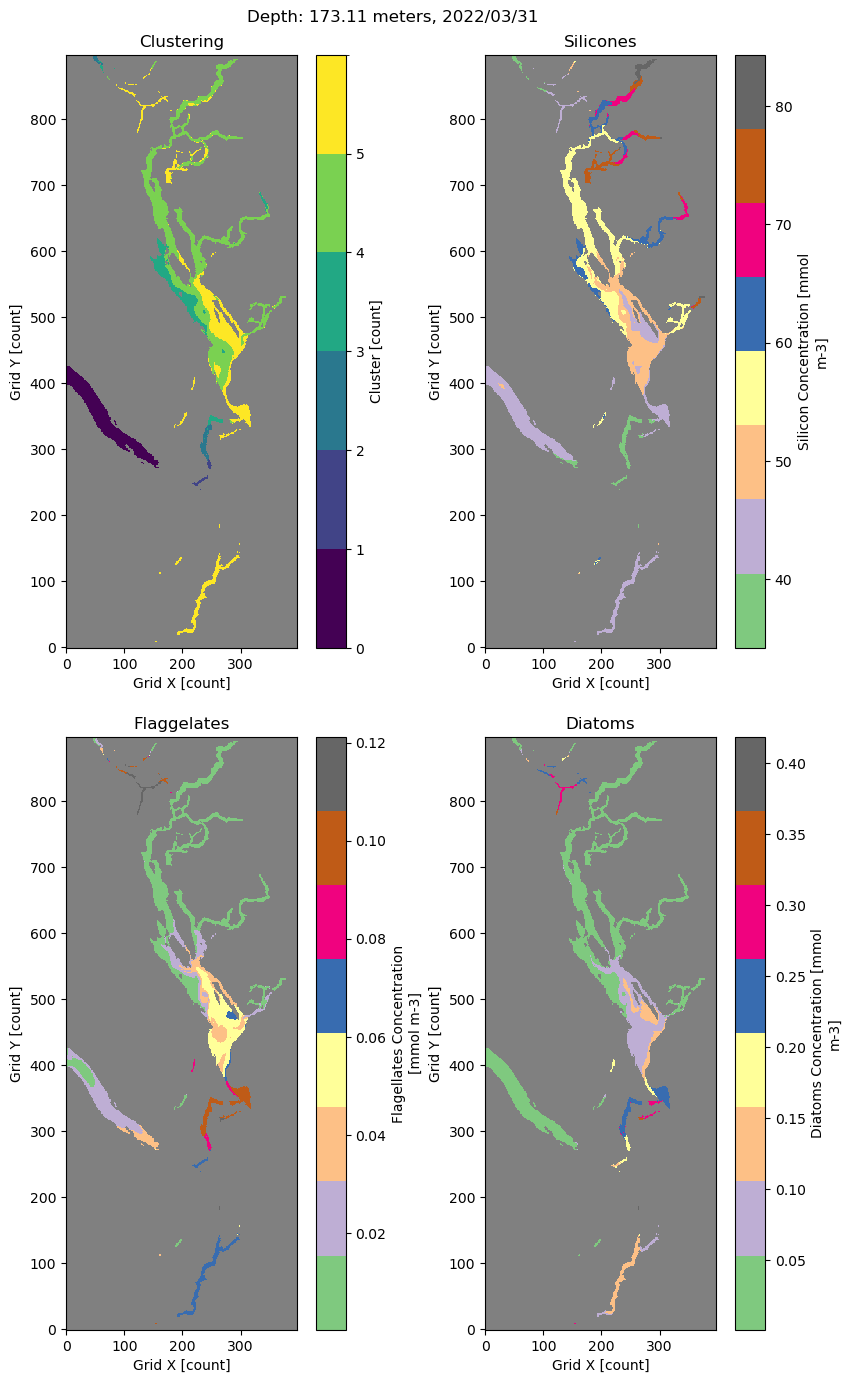

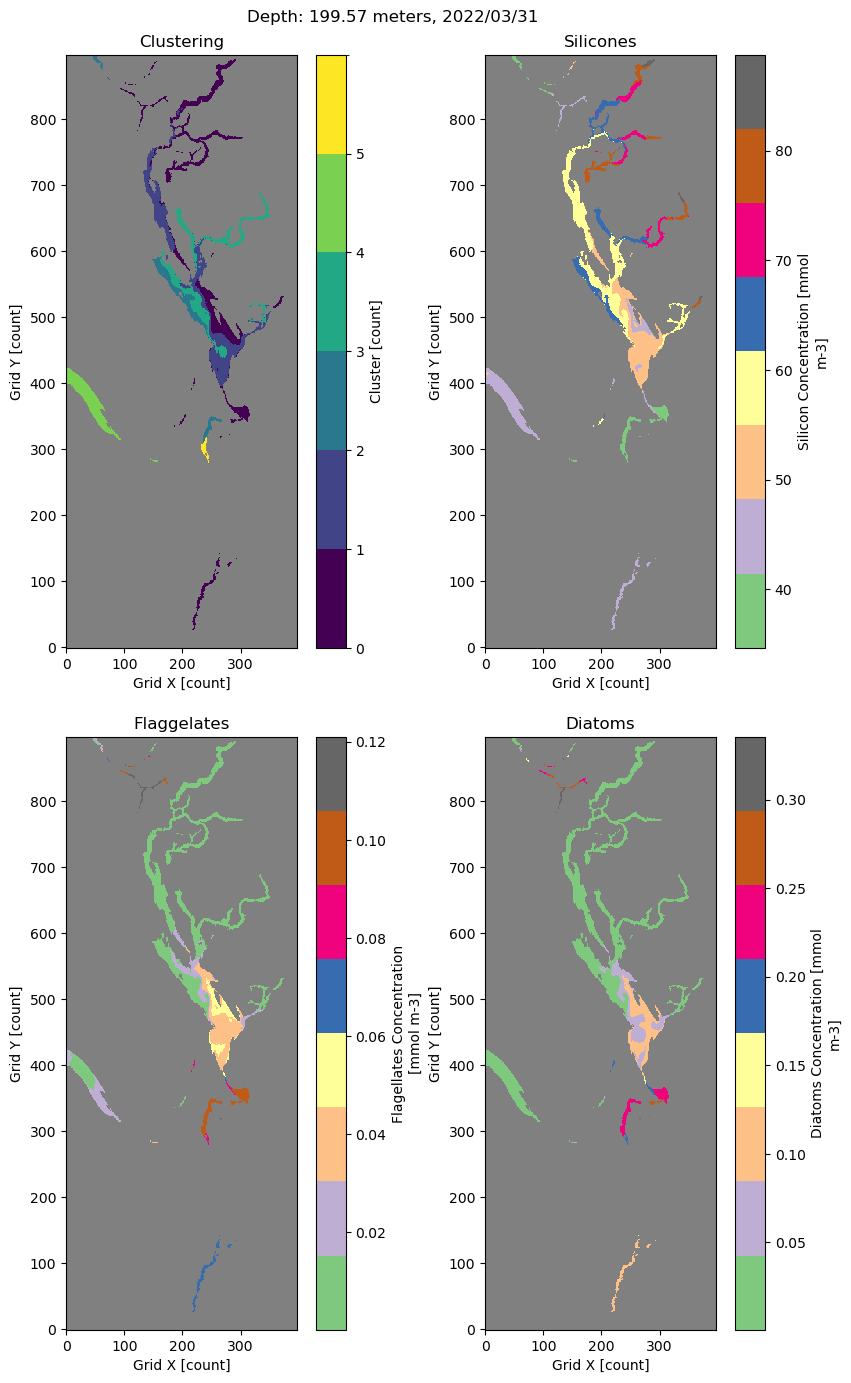

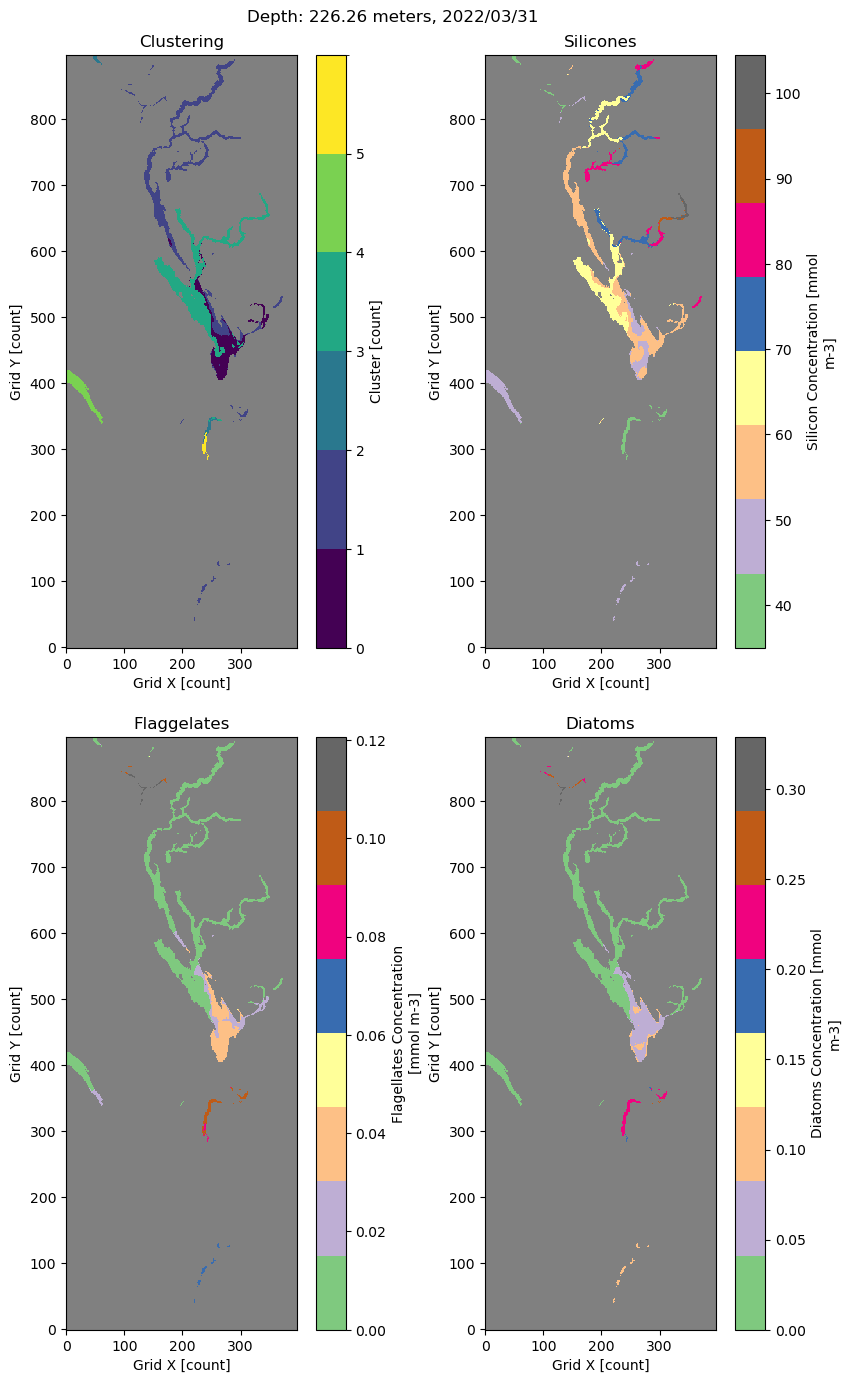

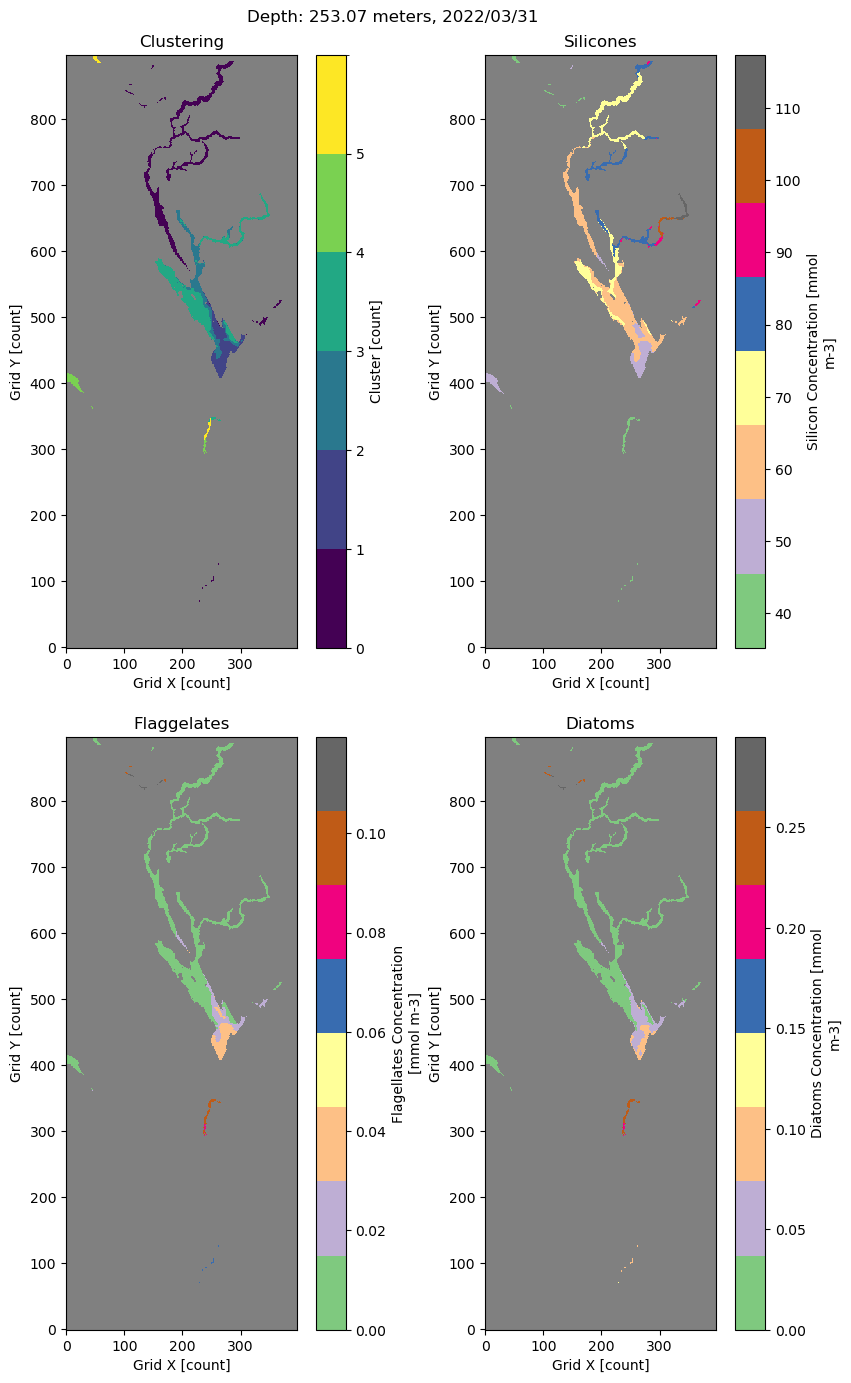

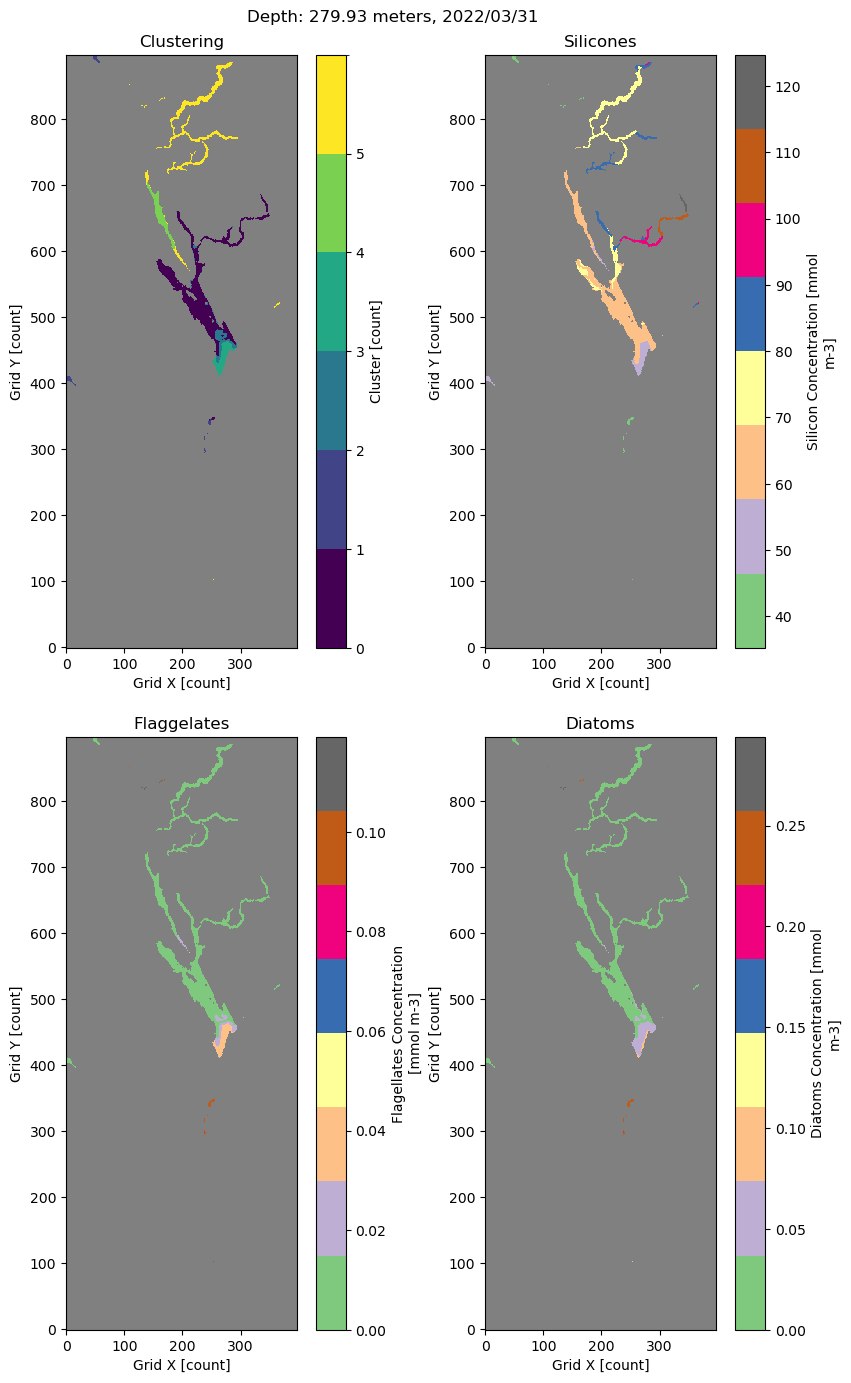

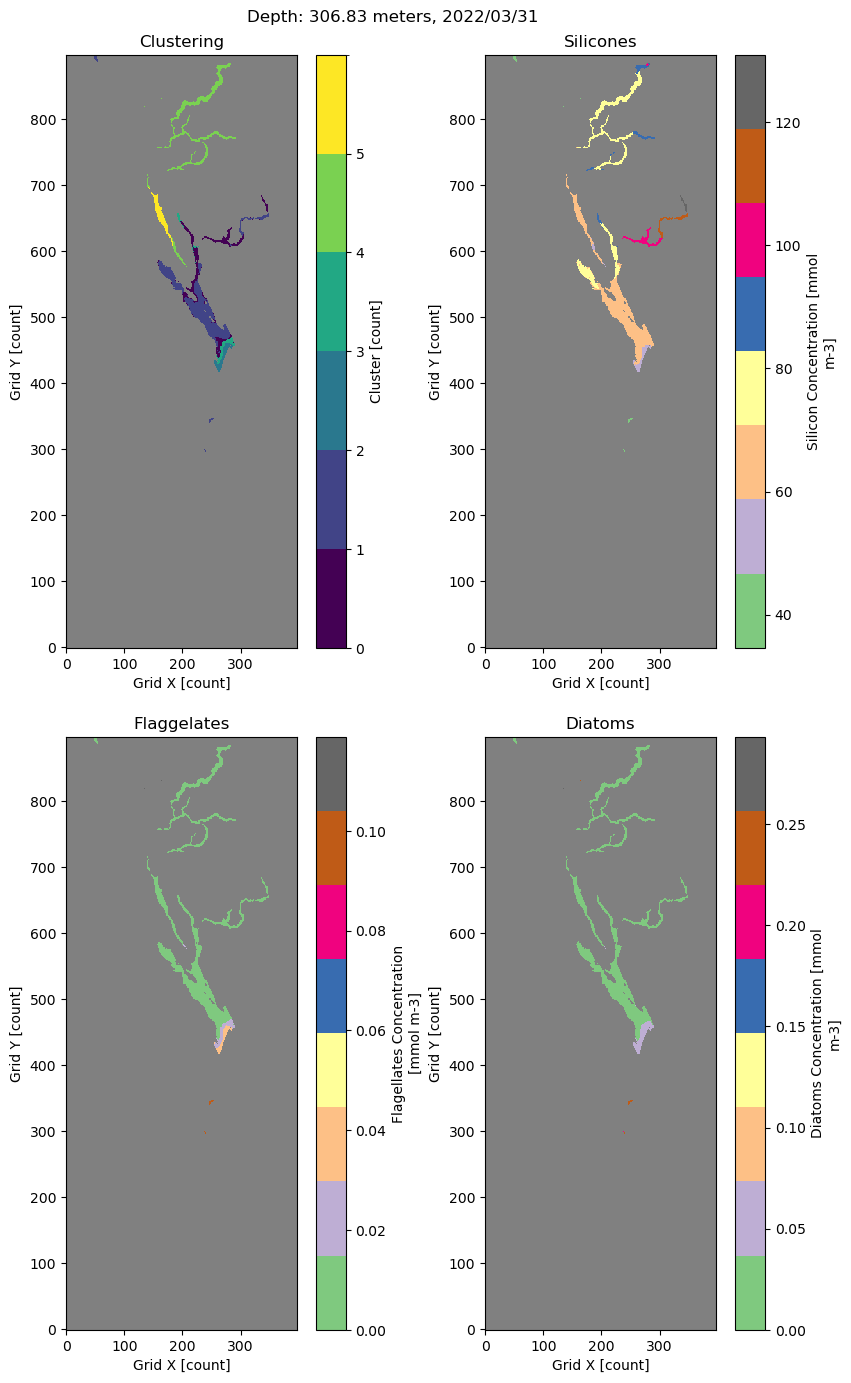

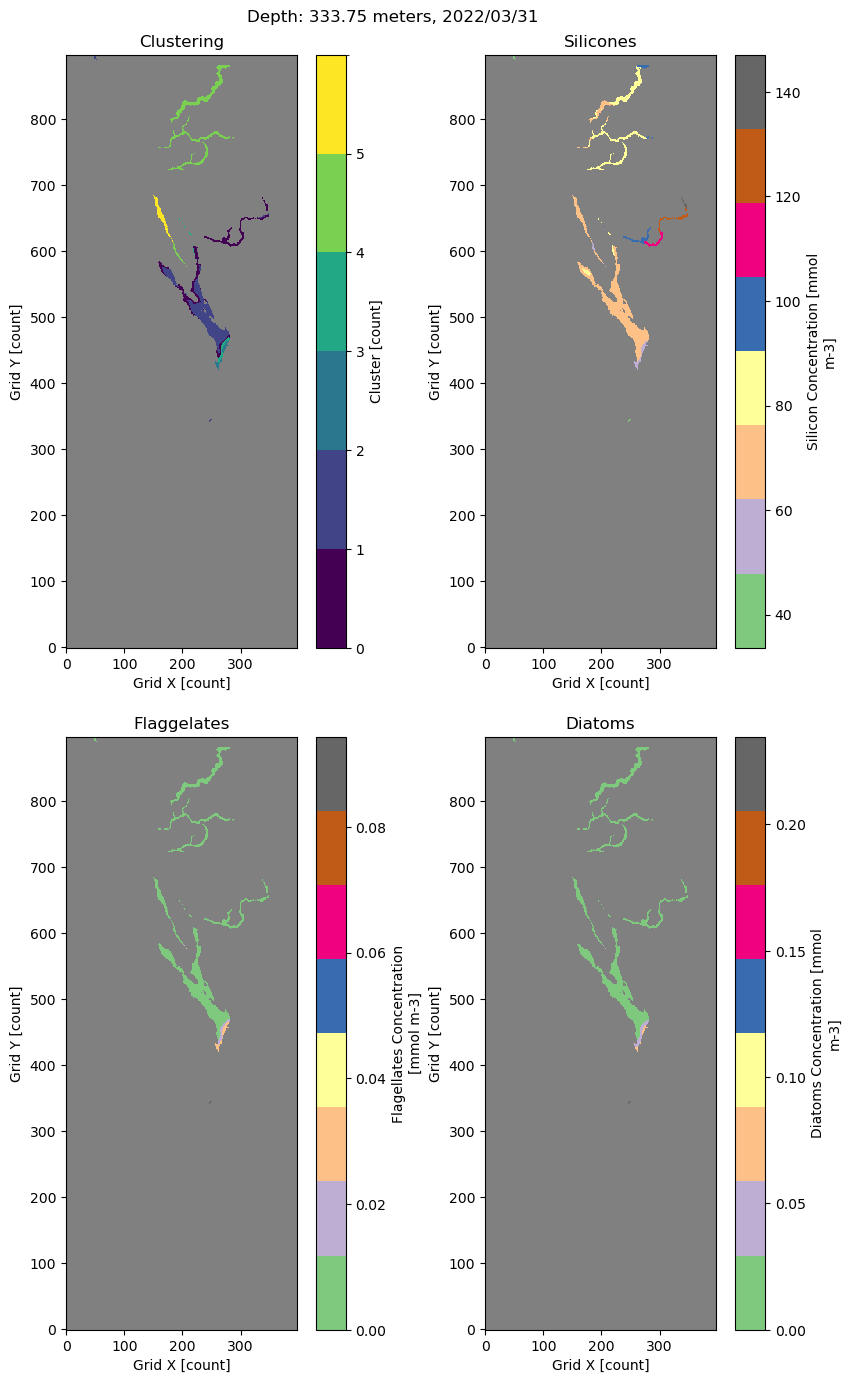

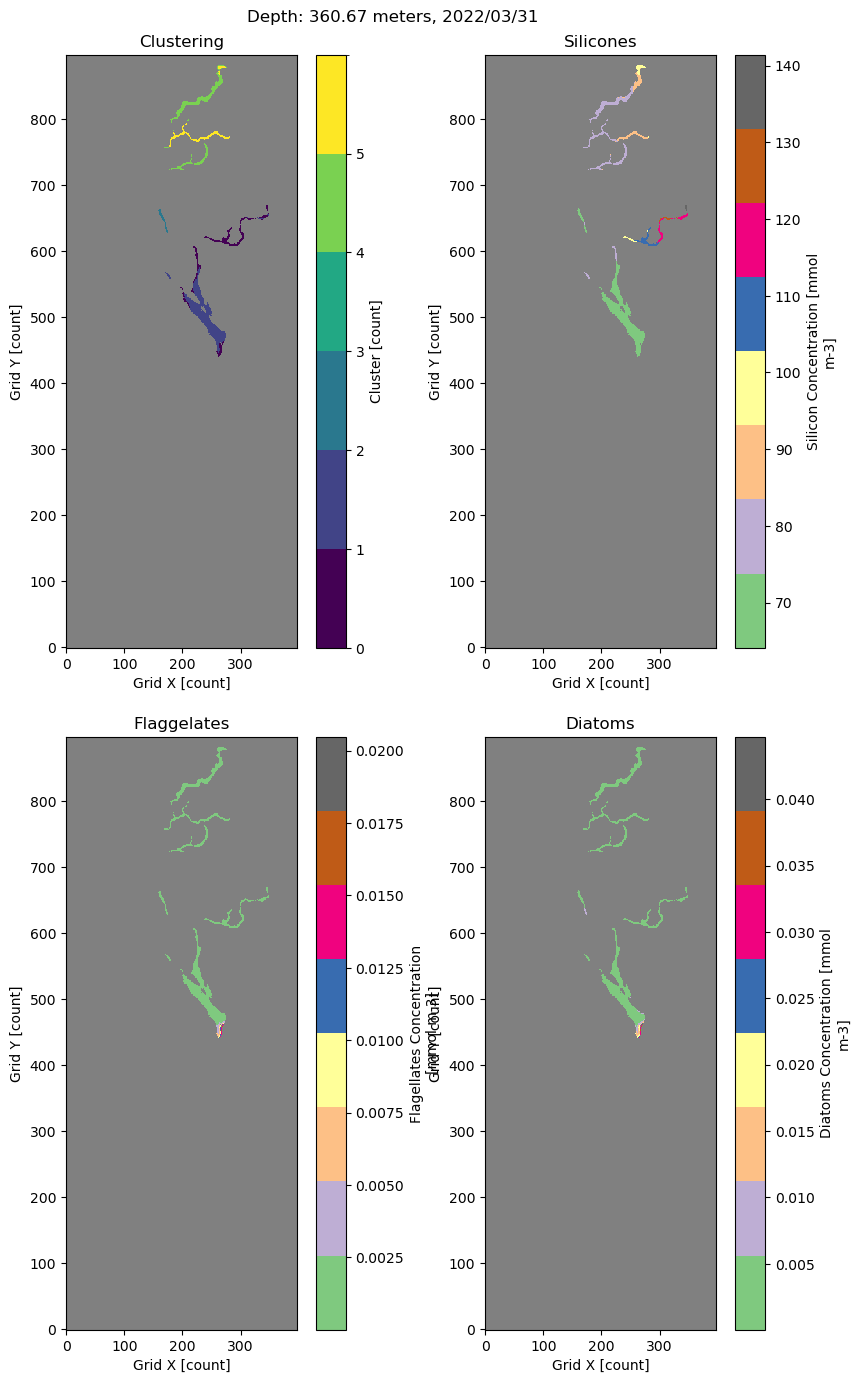

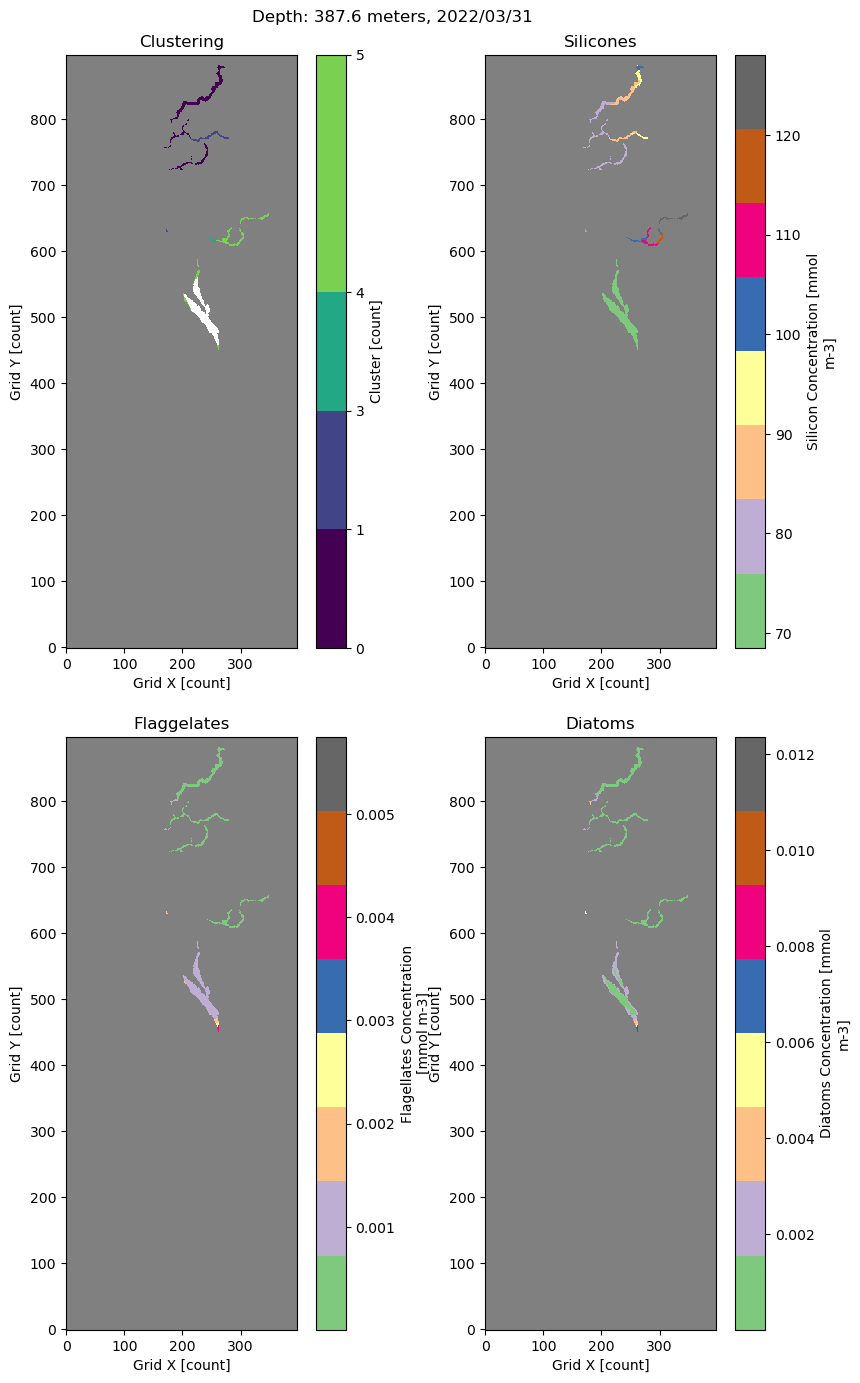

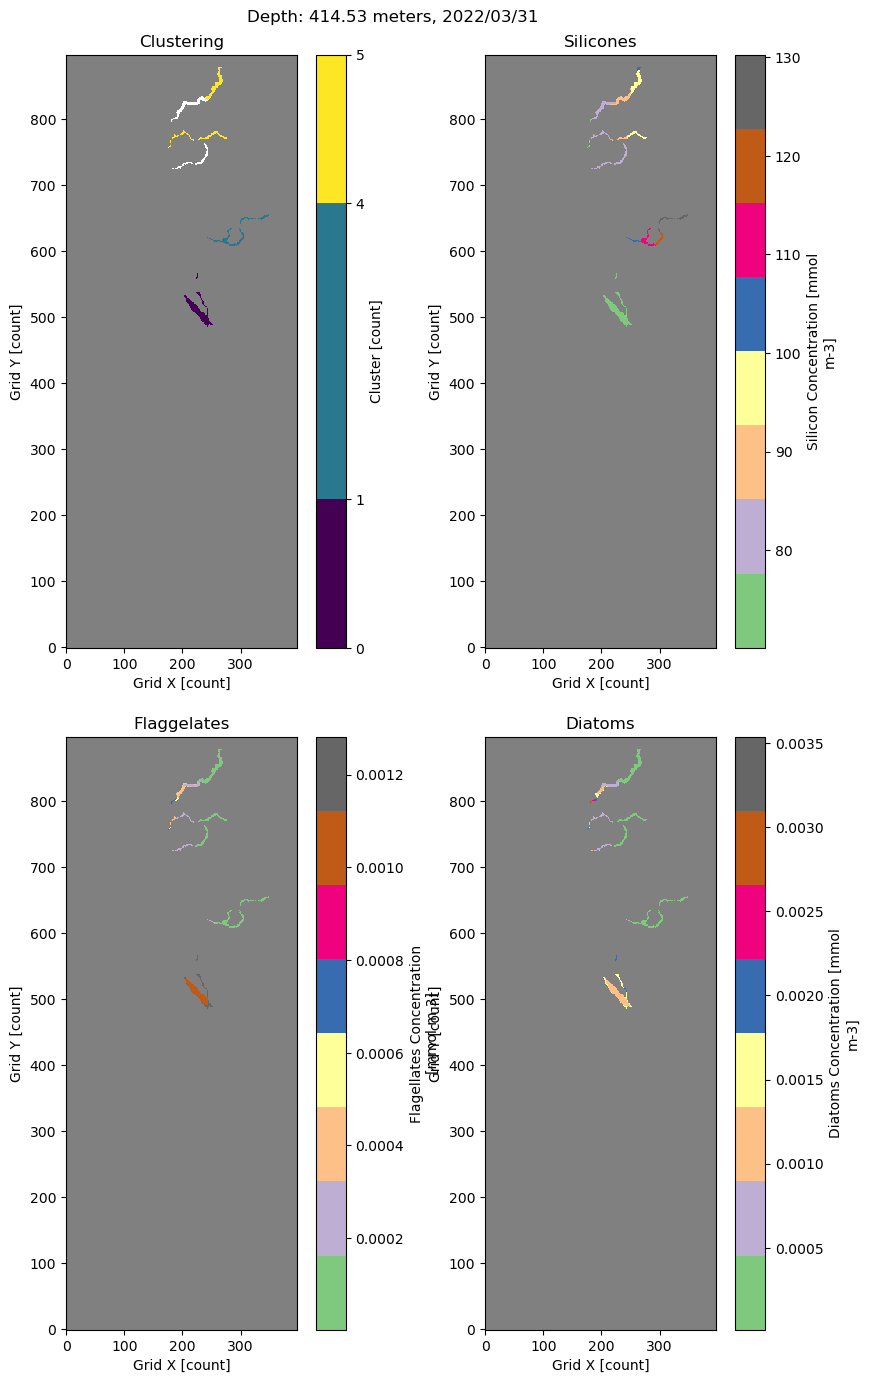

ValueError: zero-size array to reduction operation maximum which has no identity

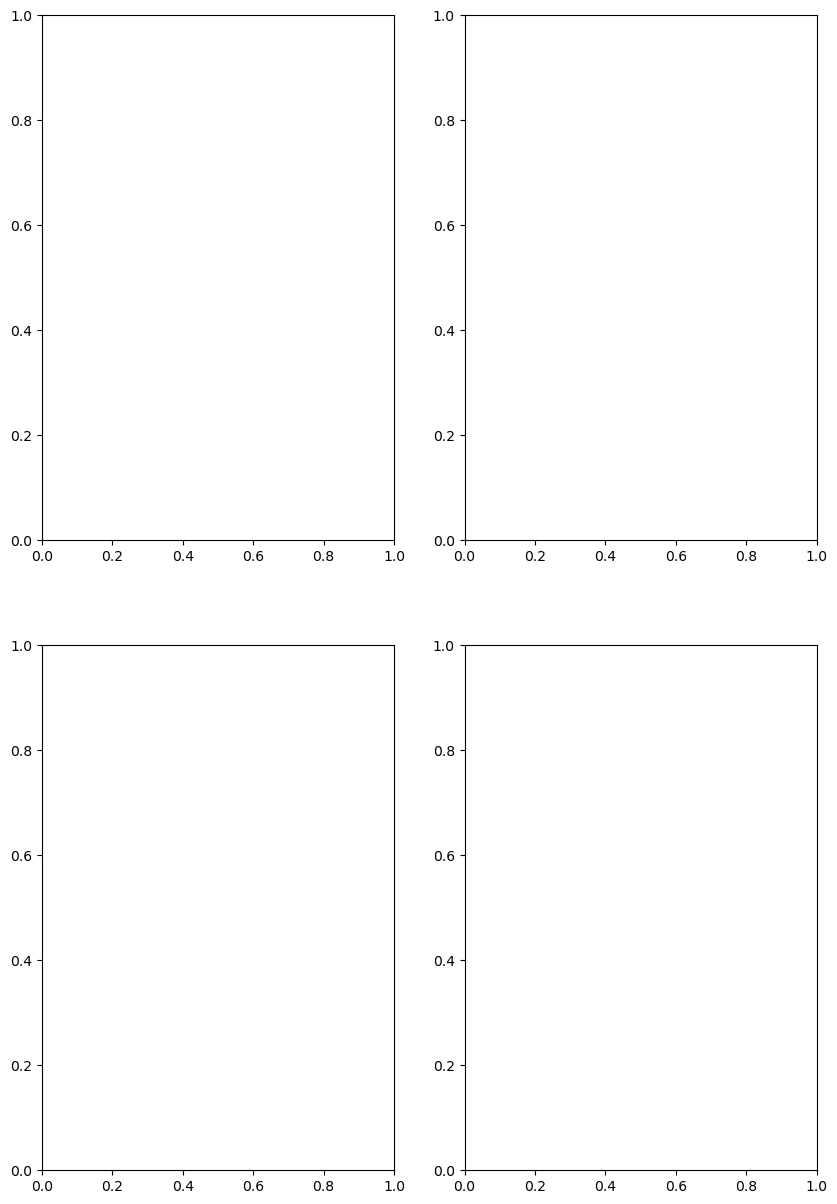

In [21]:
ds, temp, saline, date, mask, sil, flag, diat = datasets_preparation()

for depth in range (0, ds['deptht'].size+1):

    temp, saline, sil, flag, diat = masking(depth, temp, saline, mask, sil, flag, diat)
    unique, counts, inputs, predictions, clusters = som(depth, temp, saline)
    # printing(inputs, predictions, unique, counts)
    plotting (depth, clusters, unique, sil, flag, diat)
